In [1]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from galaxy2galaxy import problems
import tensorflow as tf
from scipy.ndimage import convolve
import pickle
from itertools import chain

tf.enable_eager_execution()

%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

tf.version.VERSION

'1.15.0'

In [2]:
import sys
path = '/local/home/ua264756/GitHub/ADMM/'
sys.path.insert(1, path)

import plot_utils
from helper_func import *

data_path = '/local/home/ua264756/Data/'

In [3]:
tf.executing_eagerly()

True

### Loading Galaxy Images & PSF

In [4]:
# Open Batch
f = open(data_path + "meerkat_batch_2000.pkl", "rb")
batch = pickle.load(f)
f.close()

### Load Trained U-Net Model

In [5]:
model_1 = tf.keras.models.load_model(path + 'UNet_Denoiser/Models/UNet_radio_F{3600}_ep{20}spe{6250}nb{32}_WGN_fact{100}_SNR{1-50}', compile=False)

# FISTA in TensorFlow

In [6]:
# Projection - Enforce non-negative values
def proj(xi):
    
    return tf.cast(tf.math.maximum(xi, 0.0), tf.float32)

 
# H operator
def H(data, psf):
    
    return fftconvolve(data, psf)


# H transpose operator
def Ht(data, psf):
    
    return fftconvolve(data, tf.reverse(tf.reverse(psf, axis=[0]), axis=[1]))      # rotate by 180


# The gradient
def grad(y, x_rec, psf):

    return Ht(H(x_rec, psf) - y, psf)


# The cost function
def cost_func(y, x_rec, psf, var):

    L_d = (tf.cast(0.5, tf.float32) / var) * tf.norm(y - H(x_rec, psf))**2
    return tf.keras.backend.eval(L_d)


# Spectral value
def max_sv(psf):
    
    H = tf.signal.fft2d(tf.cast(psf, tf.complex64))
    normH = tf.math.abs(tf.reverse(tf.reverse(H, axis=[0]), axis=[1]) * H) 
    return tf.cast(tf.math.reduce_max(normH), tf.float32)
     
    
# Compute gradient step size   
def get_alpha(sv):

    return (tf.cast(1.0, tf.float32) / (sv * tf.cast(1.0 + 1.0e-5, tf.float32)))


# Run FISTA
def runFISTA(y, x_0, psf, grad, sigma_noise, n_iter, model):   
    
    # Convert arrays to tensors 
    x_0 = tf.cast(x_0, tf.float32) 
    
    # declare variables 
    cost = np.full(n_iter, np.inf)
    nmse_arr = np.full(n_iter, np.inf)

    # FISTA parameters  
    x_k = x_0
    t_k = tf.cast(1.0, tf.float32)
    sigma = tf.cast(sigma_noise, tf.float32)
      
    # square of spectral radius of convolution matrix
    sv = max_sv(psf)           

    # The gradient descent step
    alpha = get_alpha(sv) 
    
    
    for k in range(n_iter): 
        
        ## FISTA update
        x_k1 = x_k - alpha * grad(y, x_k, psf) 
        x_k1 = proj(x_k1)      
                                            
        t_k1 = ( (tf.cast(1.0, tf.float32) + tf.math.sqrt(tf.cast(4.0, tf.float32)*t_k**2 + tf.cast(1.0, tf.float32))) 
                / tf.cast(2.0, tf.float32) )
        
        lambda_fista = tf.cast(1.0, tf.float32) + (t_k -  tf.cast(1.0, tf.float32)) / t_k1
        x_k1 = x_k + lambda_fista * (x_k1 - x_k)                 

        
        # U-Net Denoising   
        x_k1 = tf.expand_dims(tf.expand_dims(x_k1, axis=0), axis=-1)
        x_k1 = tf.cast(tf.squeeze(model(x_k1)), tf.float32)

        ## Cost
        cost[k] = cost_func(y, x_k1, psf, var=sigma**2)            
        
        # Update variables
        x_k = x_k1
        t_k = t_k1 
        
        # Compute NMSE  
        nmse_arr[k] = nmse(gal_target, x_k)    
        
        # Stopping Criteria
        if (np.abs(nmse_arr[k]-nmse_arr[k-1]) < 1e-4) or (np.abs(cost[k]-cost[k-1]) < 1e-4):
            return x_k, cost, nmse_arr   
        
    return x_k, cost, nmse_arr

### Run FISTA



 Galaxy Index = 1600



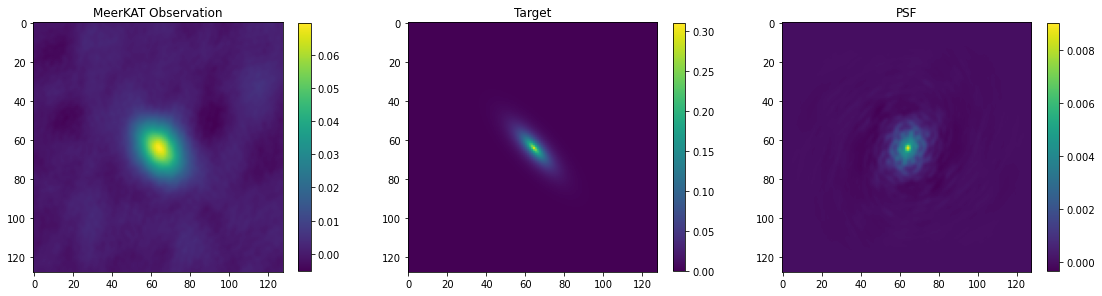

SNR (in Direct Space) = 42.34214660919456
Noise Std (in Direct Space) = 0.0016424262577900662
PSF Flux =  0.9999999



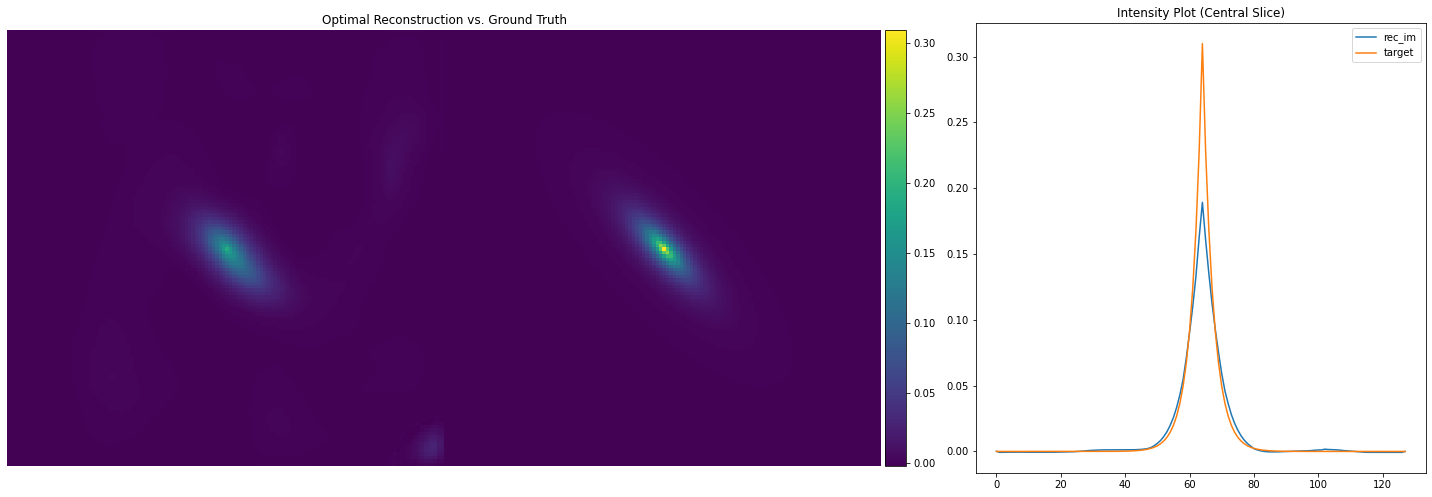

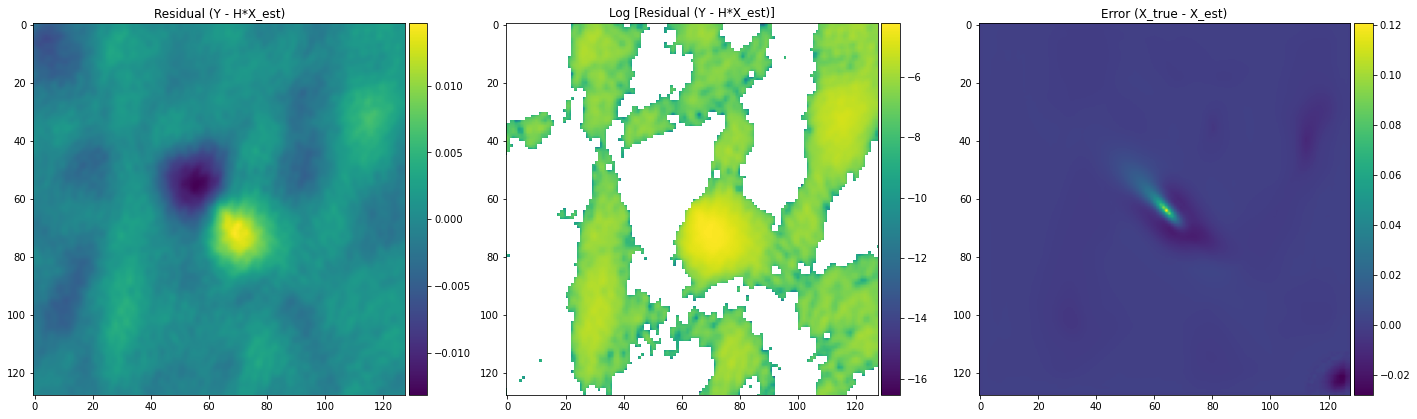

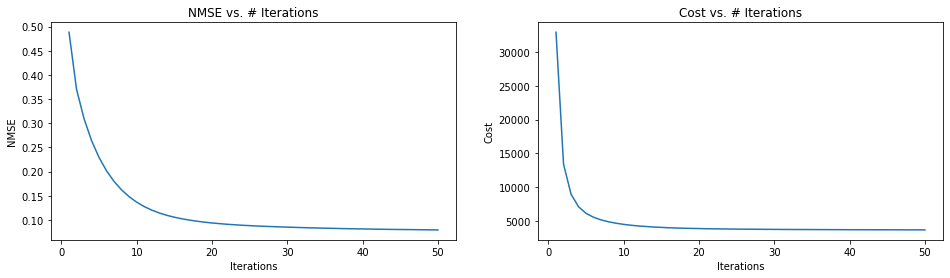


Minimum NMSE = 0.07940759509801865 (at [50] iterations)
Minimum Cost = 3635.80615234375 (at [50] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1590



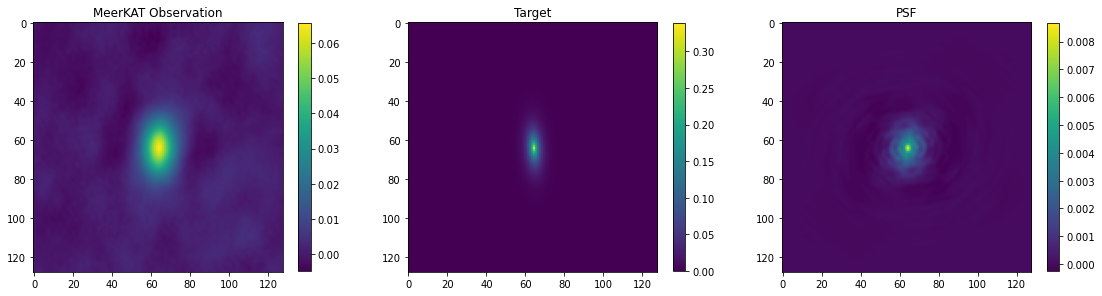

SNR (in Direct Space) = 34.862975821434276
Noise Std (in Direct Space) = 0.0018837610288057476
PSF Flux =  1.0000002



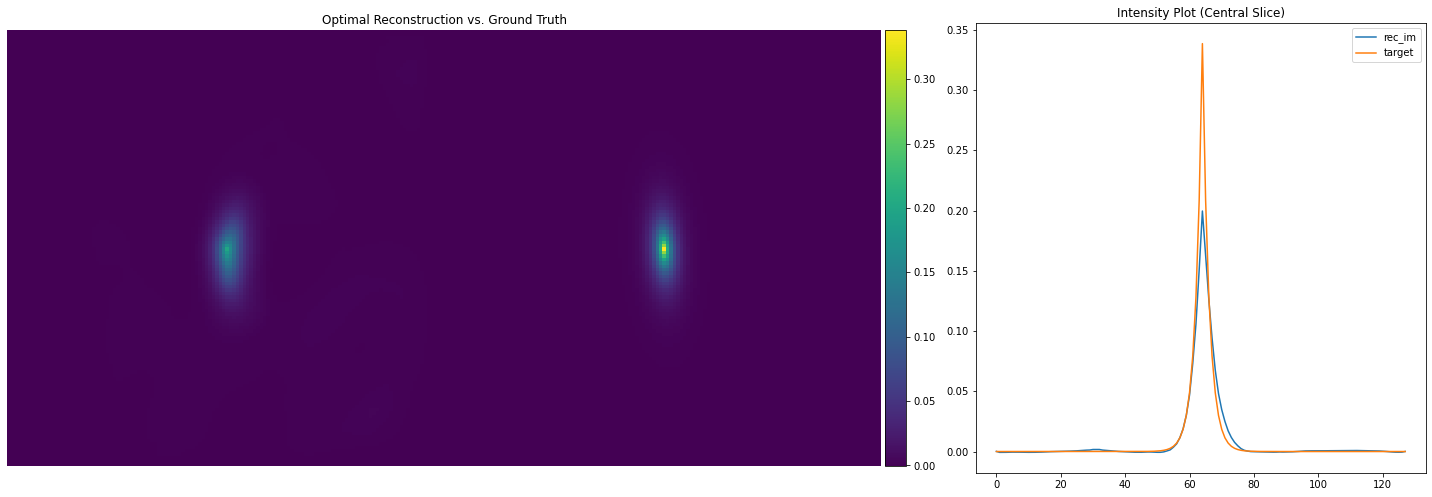

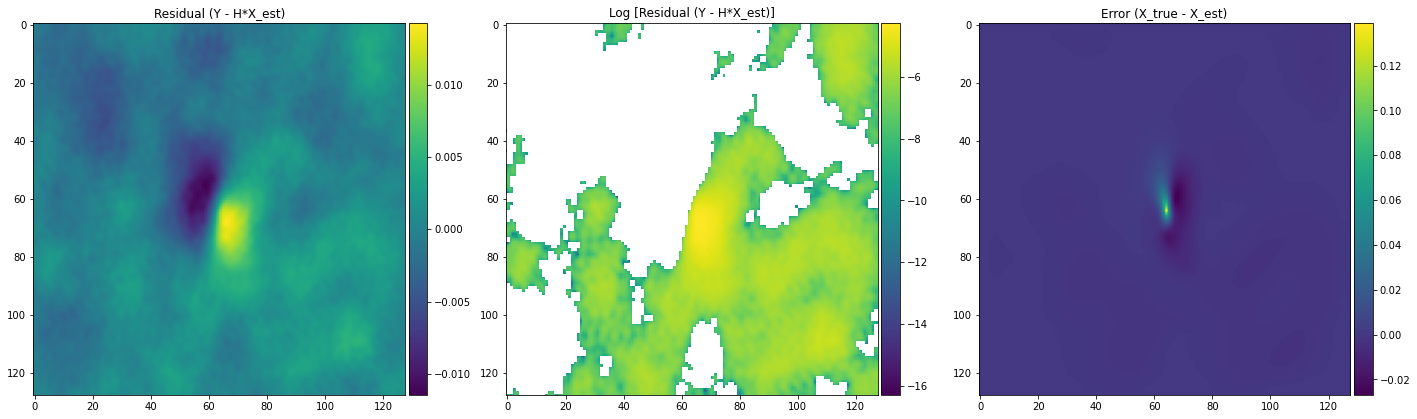

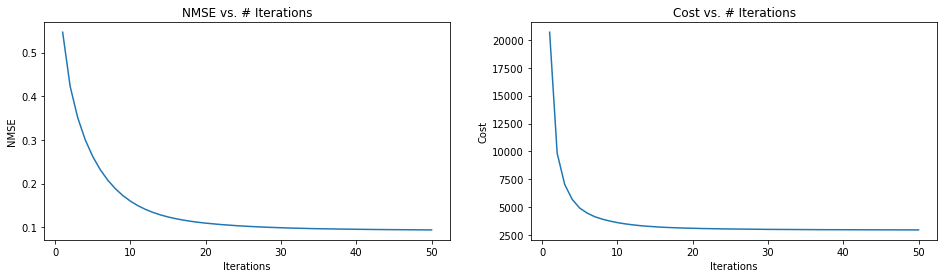


Minimum NMSE = 0.09406498819589615 (at [50] iterations)
Minimum Cost = 2973.416015625 (at [50] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1580



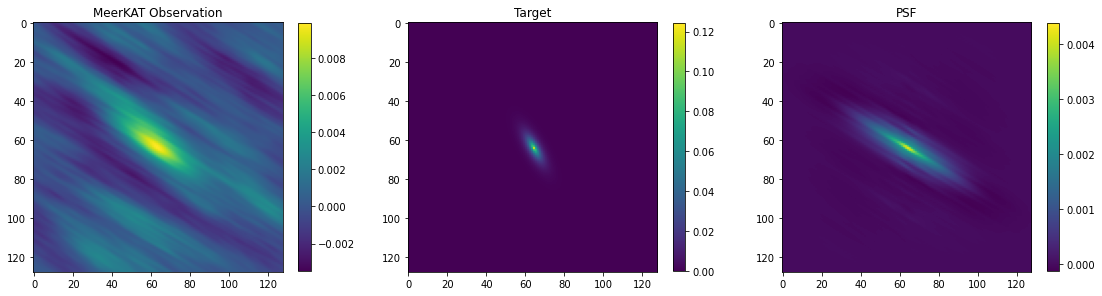

SNR (in Direct Space) = 7.04412067454325
Noise Std (in Direct Space) = 0.001400125631969422
PSF Flux =  0.9999999



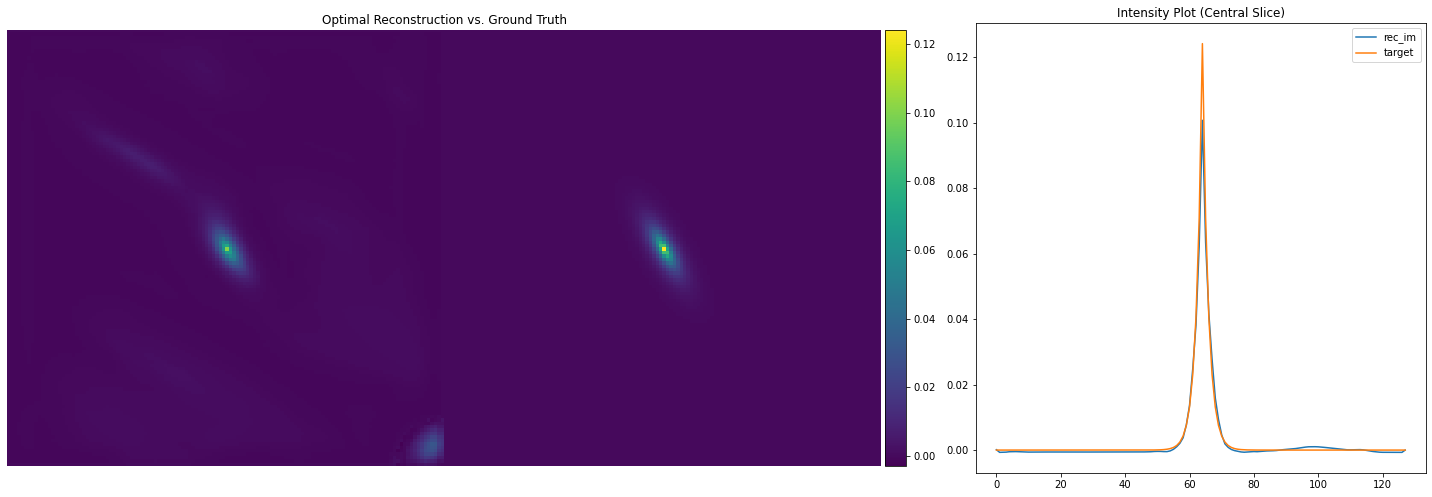

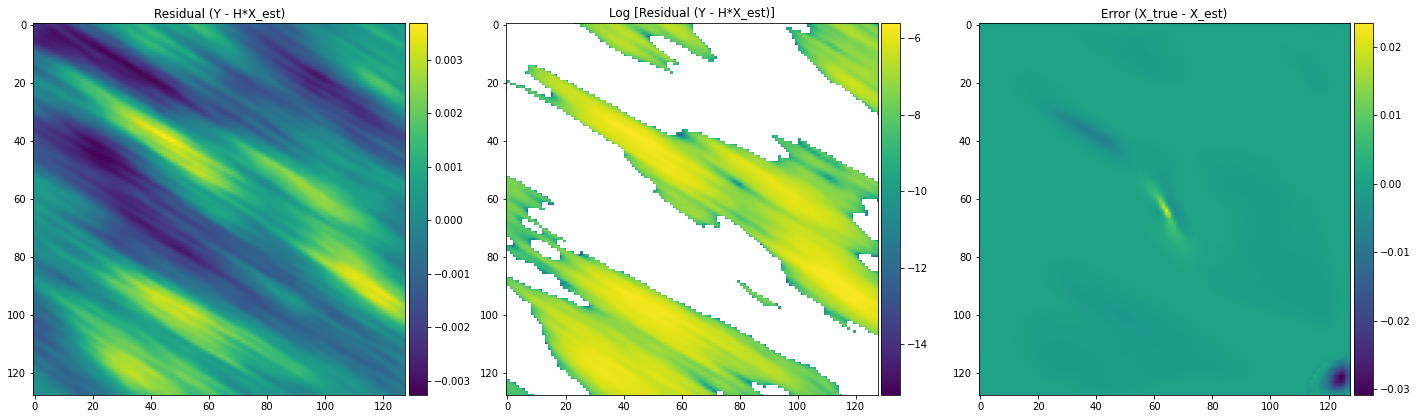

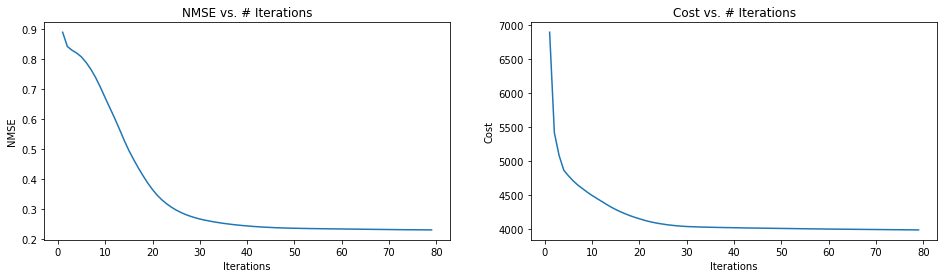


Minimum NMSE = 0.22943349182605743 (at [79] iterations)
Minimum Cost = 3989.0625 (at [79] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1570



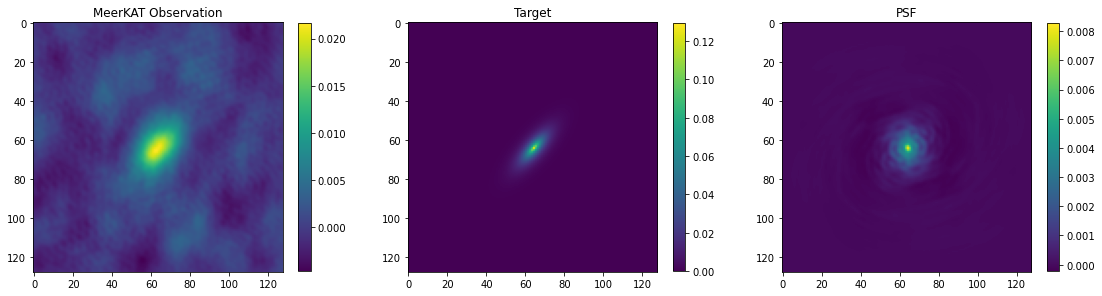

SNR (in Direct Space) = 12.730185204453113
Noise Std (in Direct Space) = 0.0016999895472312346
PSF Flux =  1.0000002



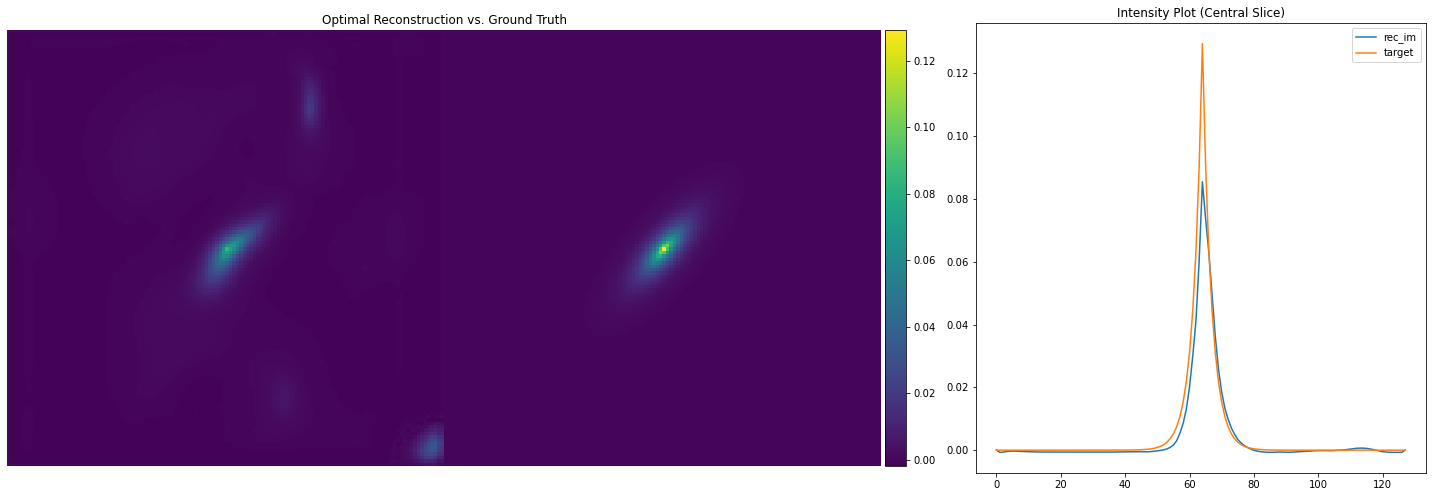

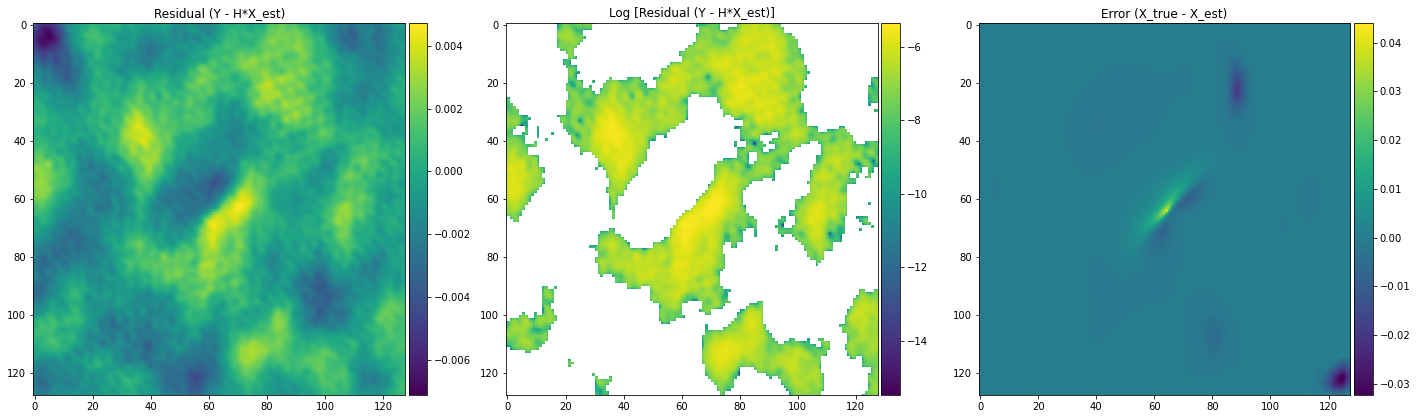

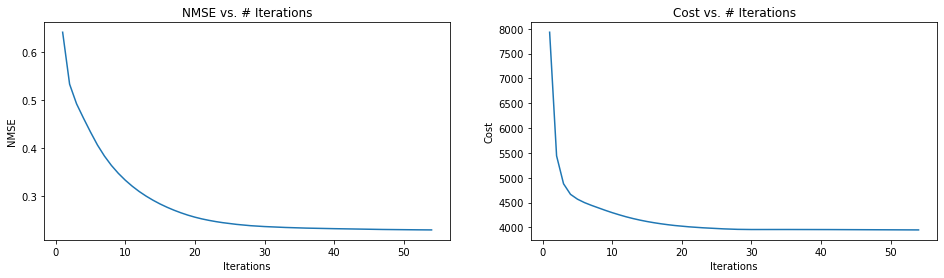


Minimum NMSE = 0.2292061299085617 (at [54] iterations)
Minimum Cost = 3948.100830078125 (at [54] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1560



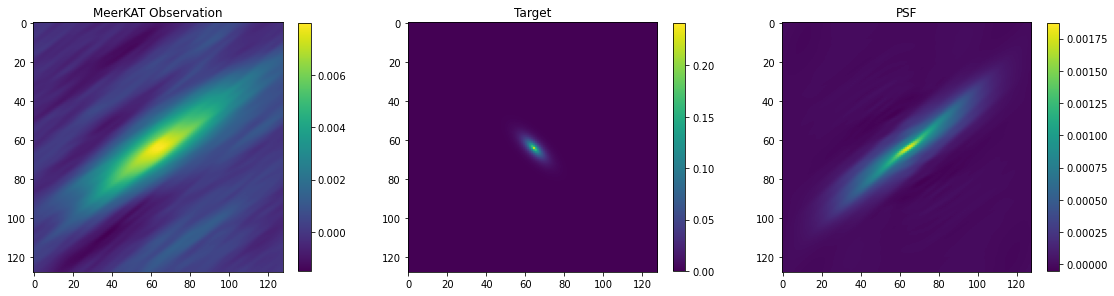

SNR (in Direct Space) = 9.504875259783834
Noise Std (in Direct Space) = 0.0008409928722074255
PSF Flux =  1.0000001



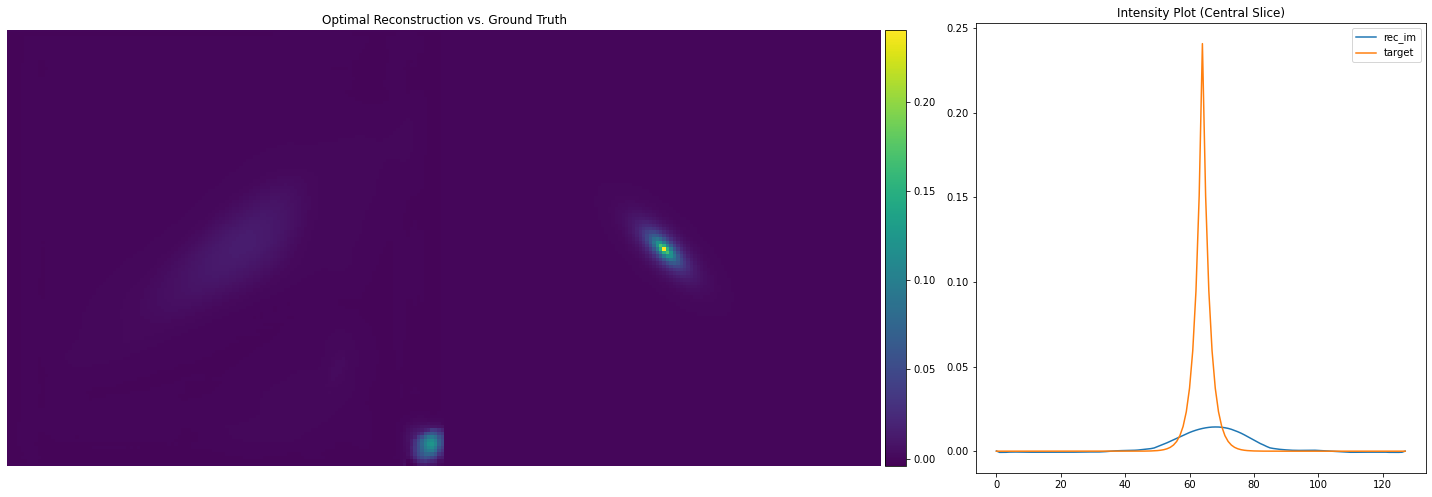

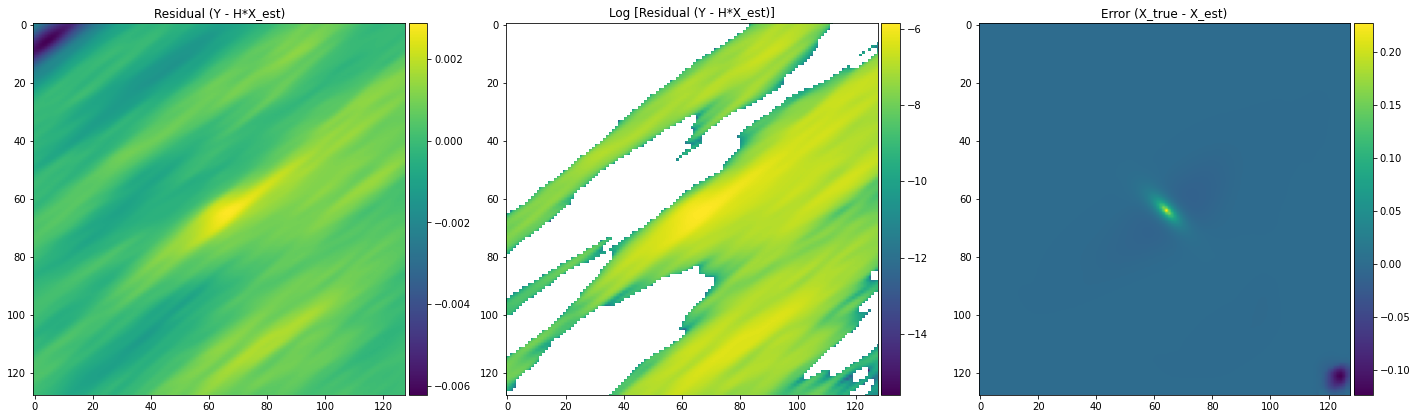

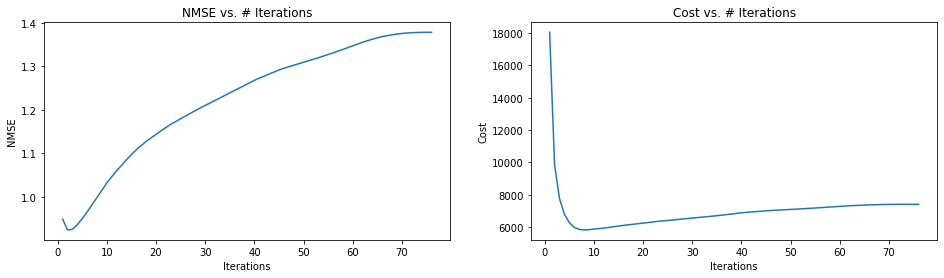


Minimum NMSE = 0.9244161248207092 (at [2] iterations)
Minimum Cost = 5823.49365234375 (at [8] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1550



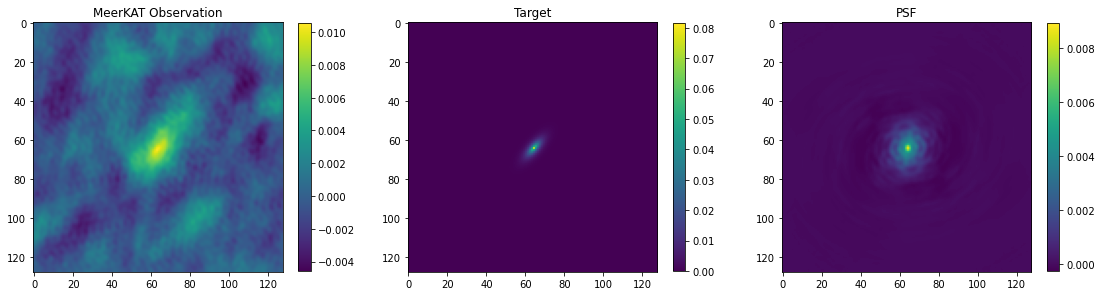

SNR (in Direct Space) = 6.977992074271551
Noise Std (in Direct Space) = 0.0015112374237505719
PSF Flux =  1.0000005



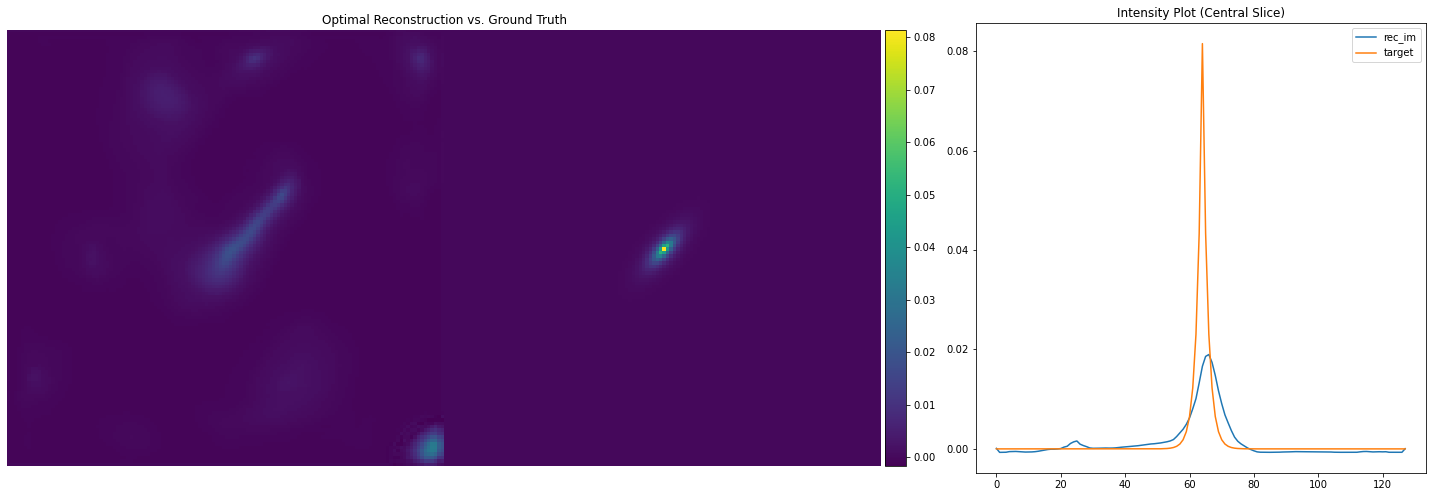

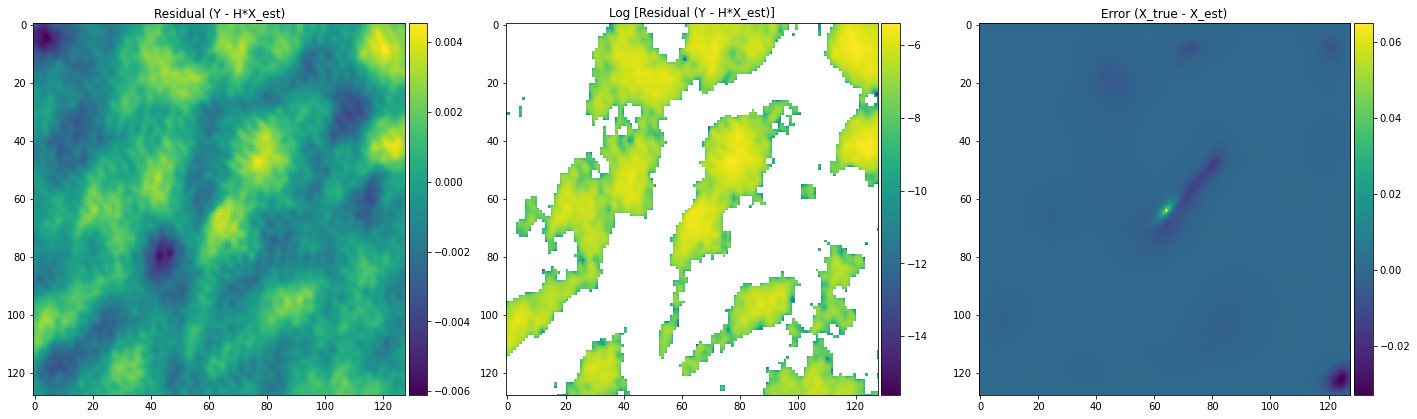

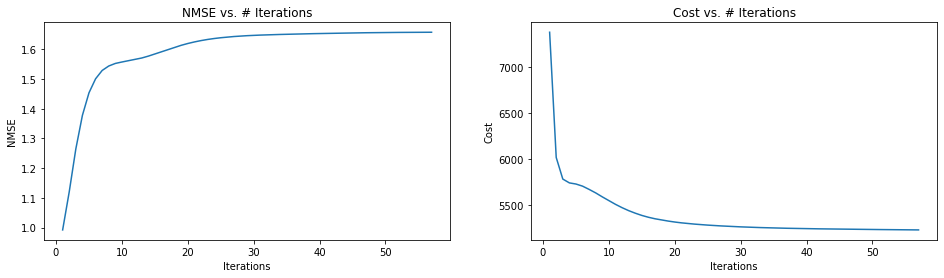


Minimum NMSE = 0.9919914603233337 (at [1] iterations)
Minimum Cost = 5229.95068359375 (at [57] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1540



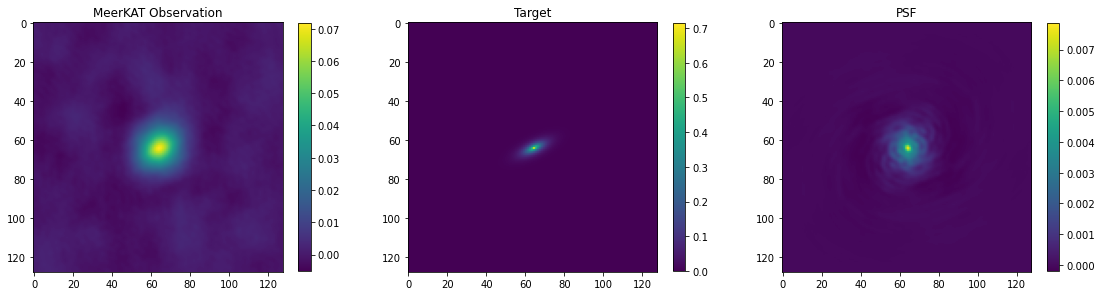

SNR (in Direct Space) = 43.46343641648287
Noise Std (in Direct Space) = 0.00164997238679789
PSF Flux =  0.99999994



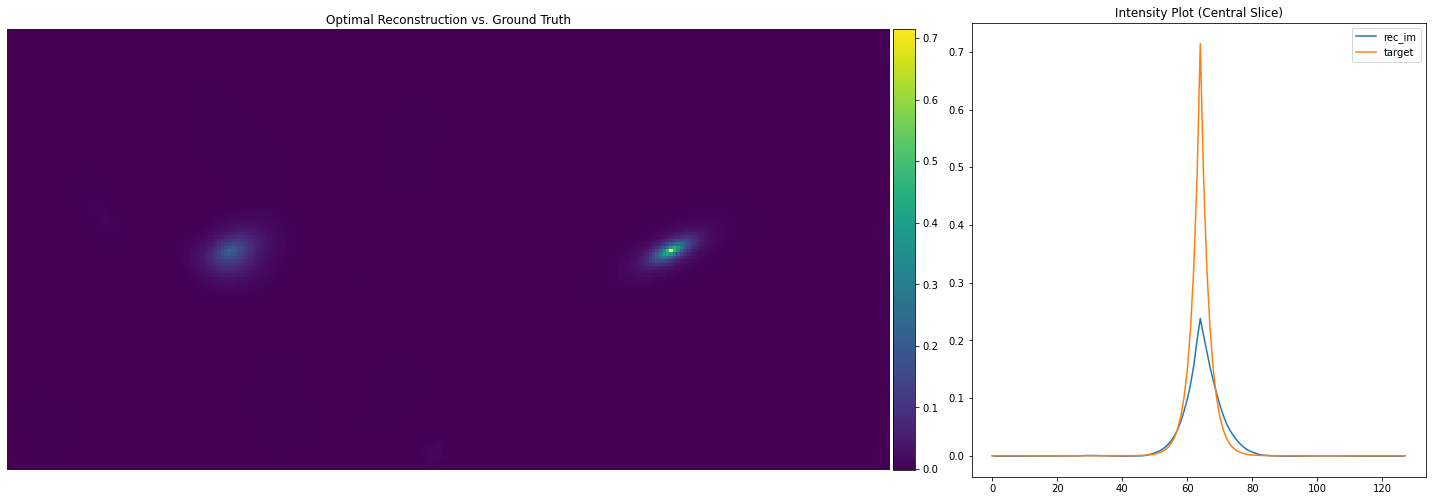

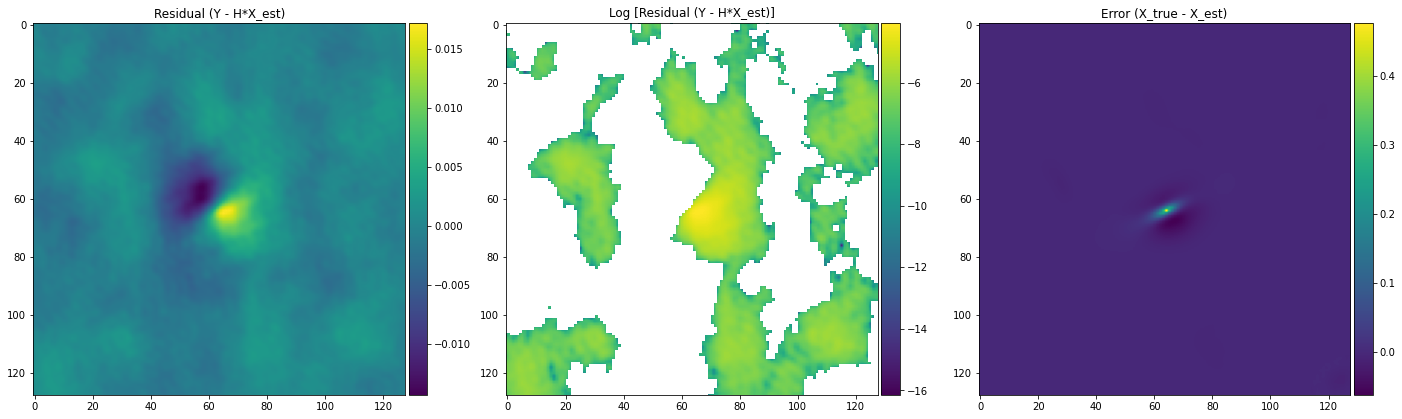

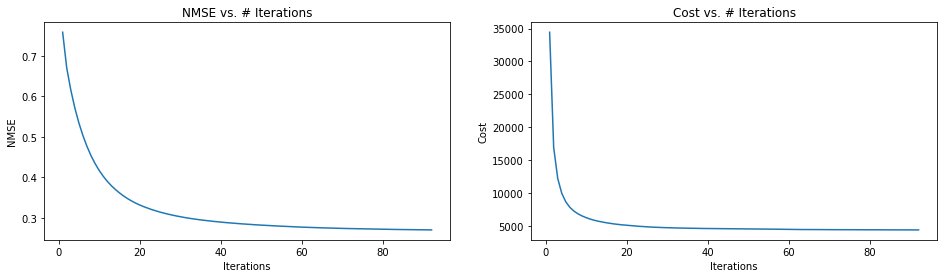


Minimum NMSE = 0.2707020938396454 (at [92] iterations)
Minimum Cost = 4421.42822265625 (at [89] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1530



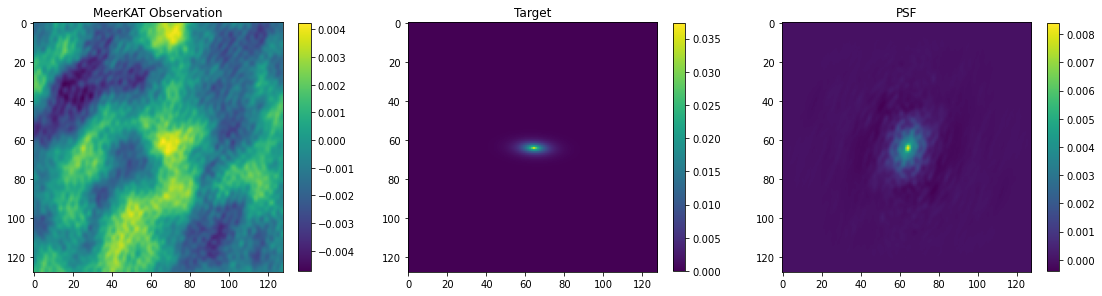

SNR (in Direct Space) = 2.348022111468689
Noise Std (in Direct Space) = 0.001798486543446779
PSF Flux =  1.0



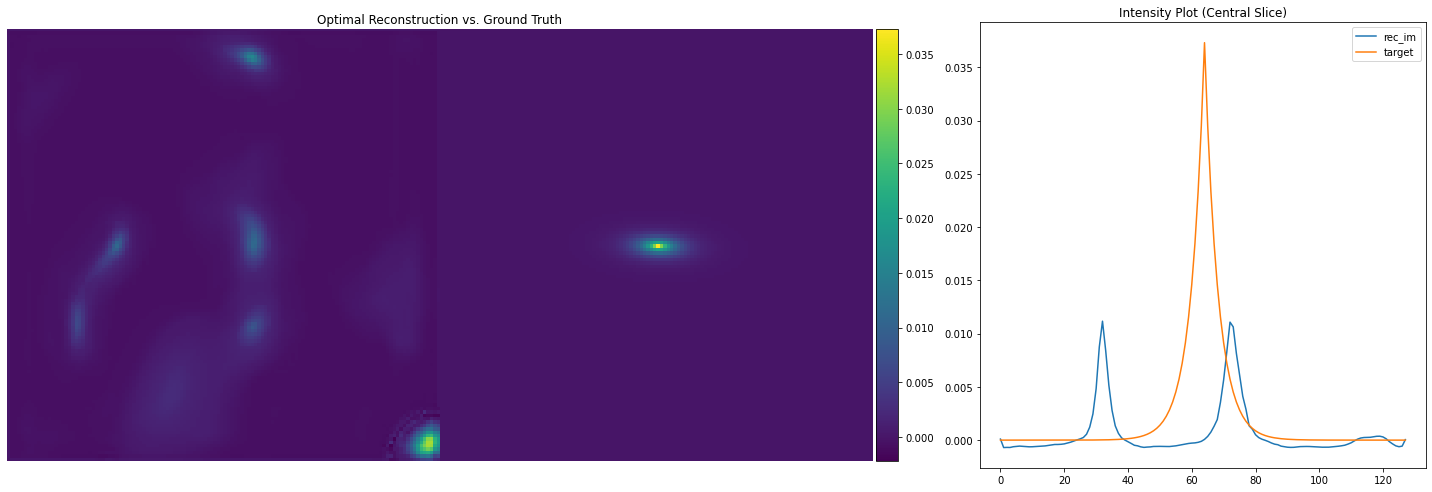

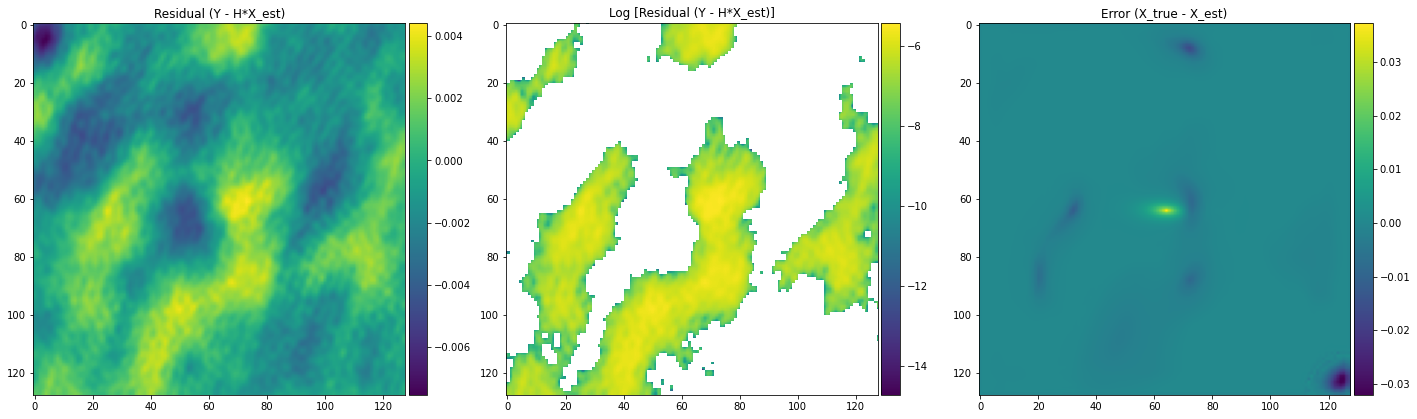

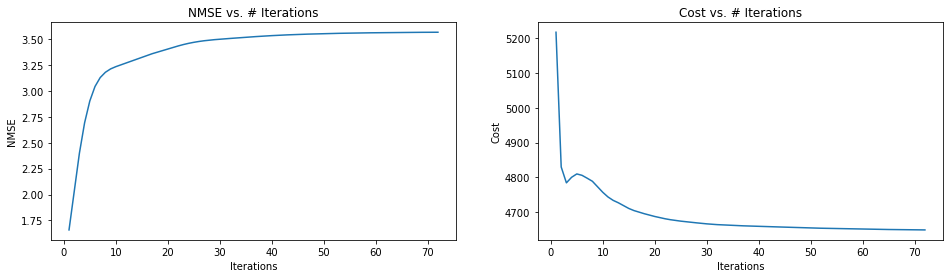


Minimum NMSE = 1.658185362815857 (at [1] iterations)
Minimum Cost = 4649.1357421875 (at [72] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1520



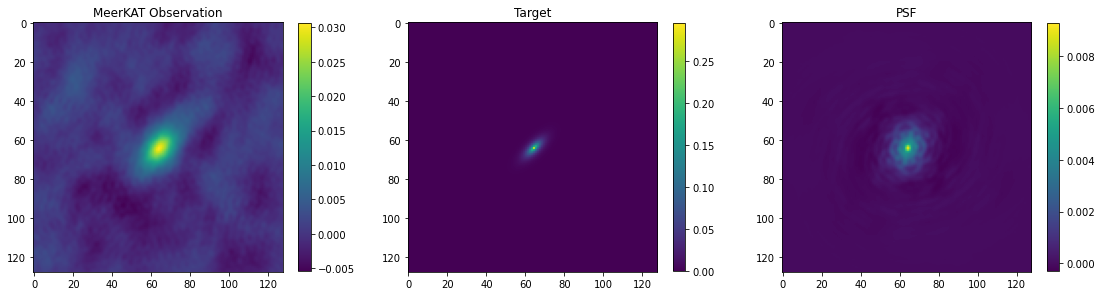

SNR (in Direct Space) = 17.357208363925498
Noise Std (in Direct Space) = 0.0017633358836872503
PSF Flux =  1.0000004



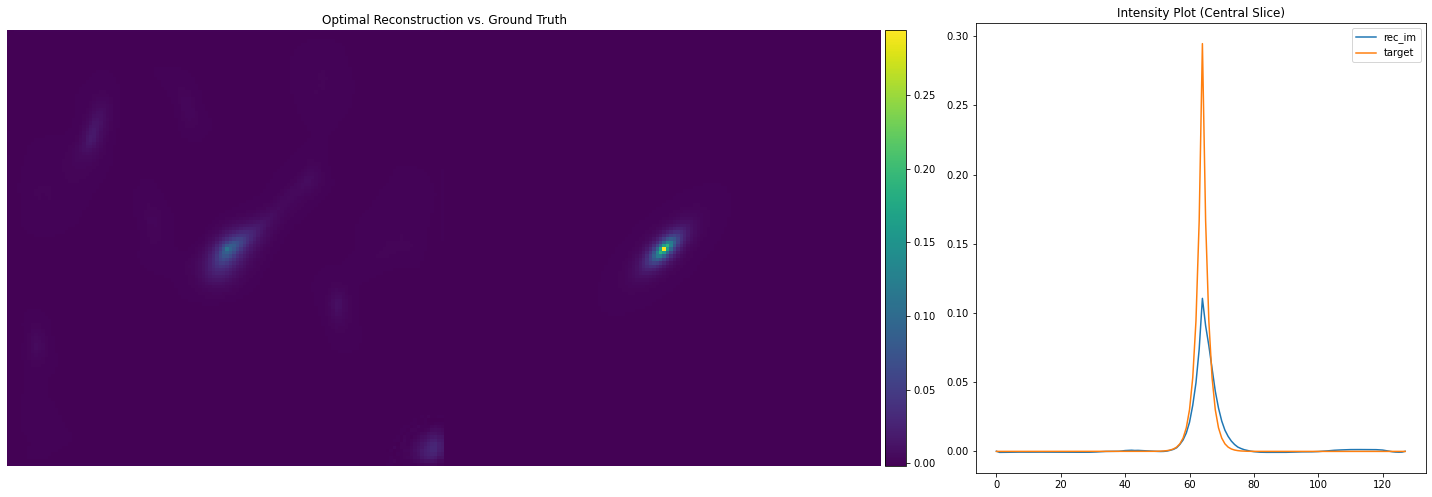

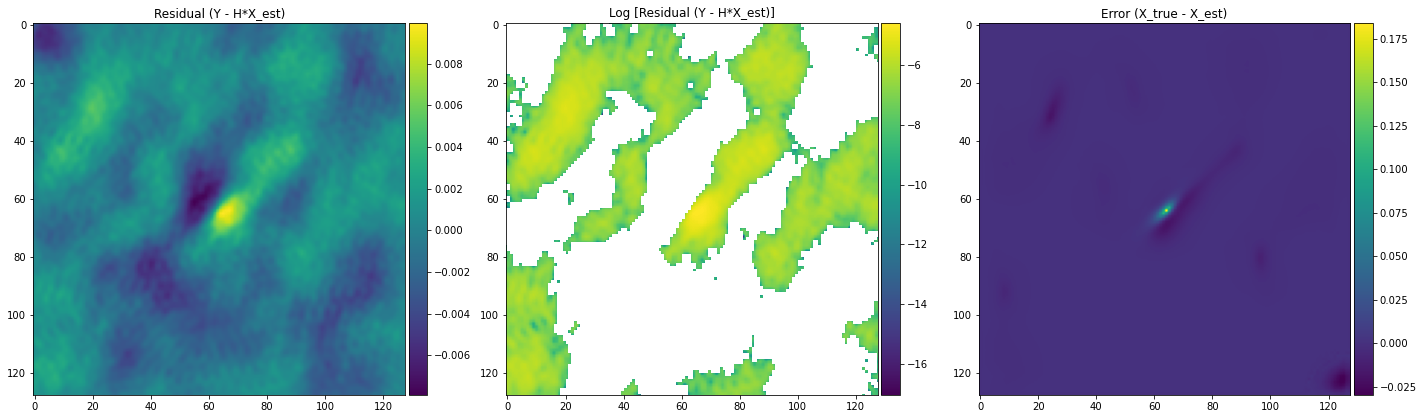

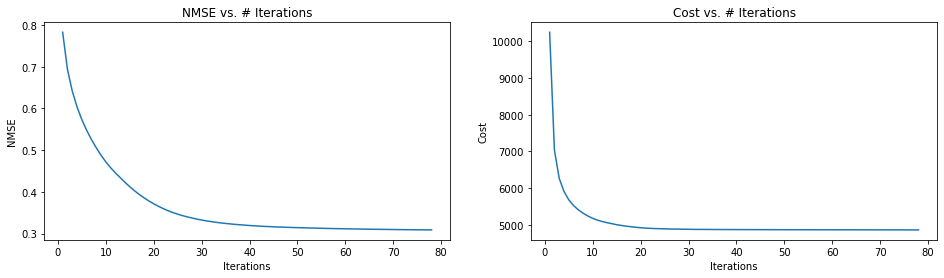


Minimum NMSE = 0.3089146018028259 (at [78] iterations)
Minimum Cost = 4864.9580078125 (at [77] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1510



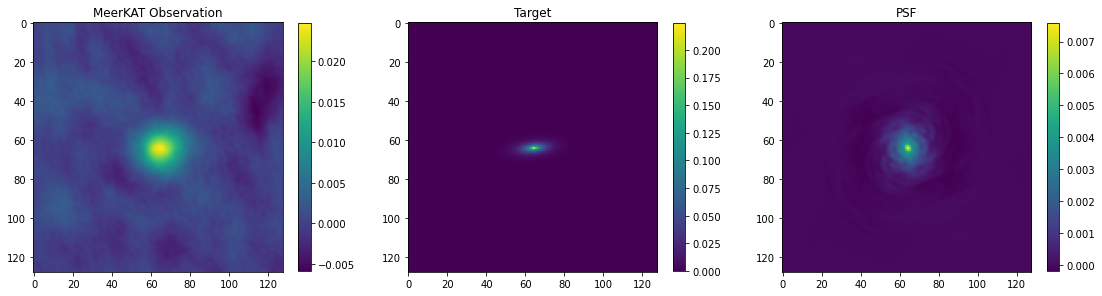

SNR (in Direct Space) = 18.821732679901896
Noise Std (in Direct Space) = 0.0013129996084724552
PSF Flux =  0.9999999



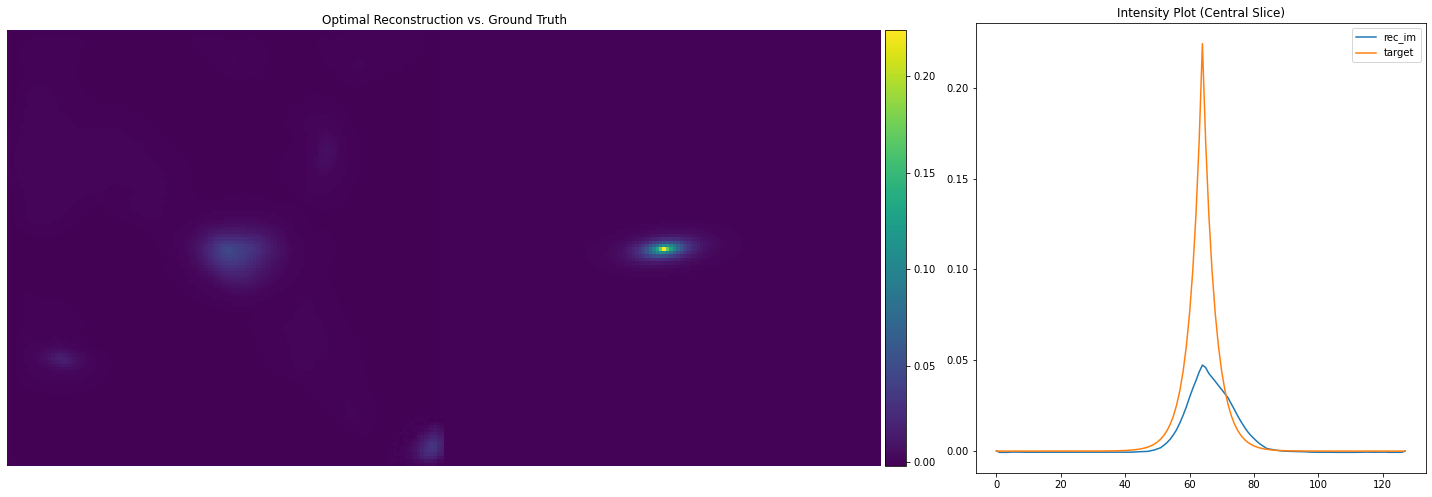

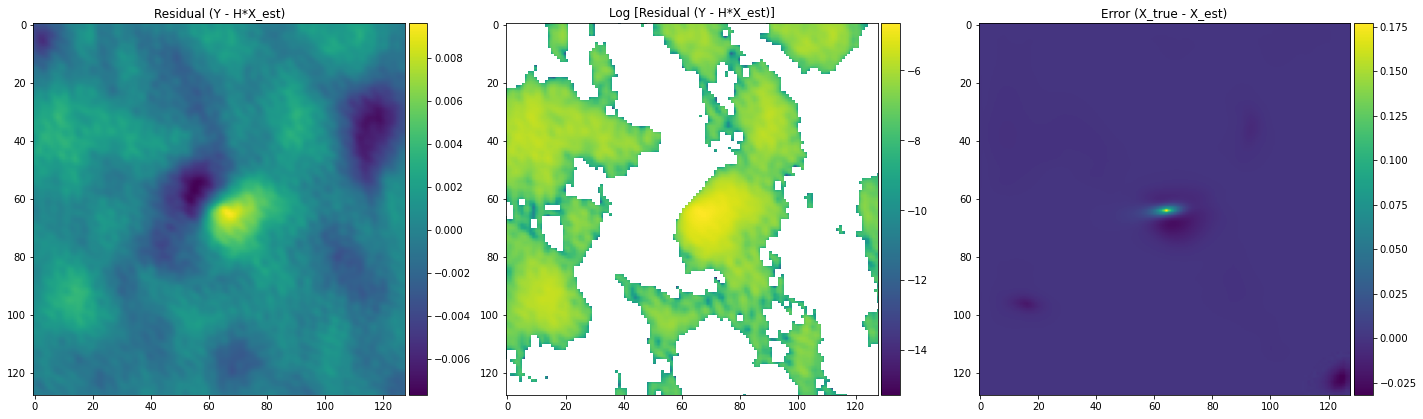

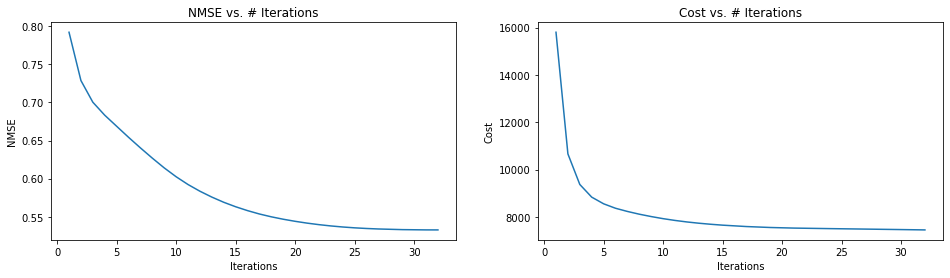


Minimum NMSE = 0.5326398015022278 (at [32] iterations)
Minimum Cost = 7447.34765625 (at [32] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1500



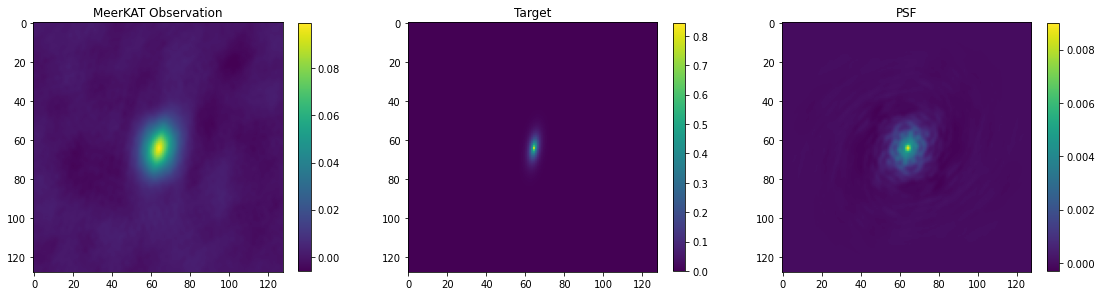

SNR (in Direct Space) = 52.8675477407672
Noise Std (in Direct Space) = 0.0018754908538889138
PSF Flux =  0.9999999



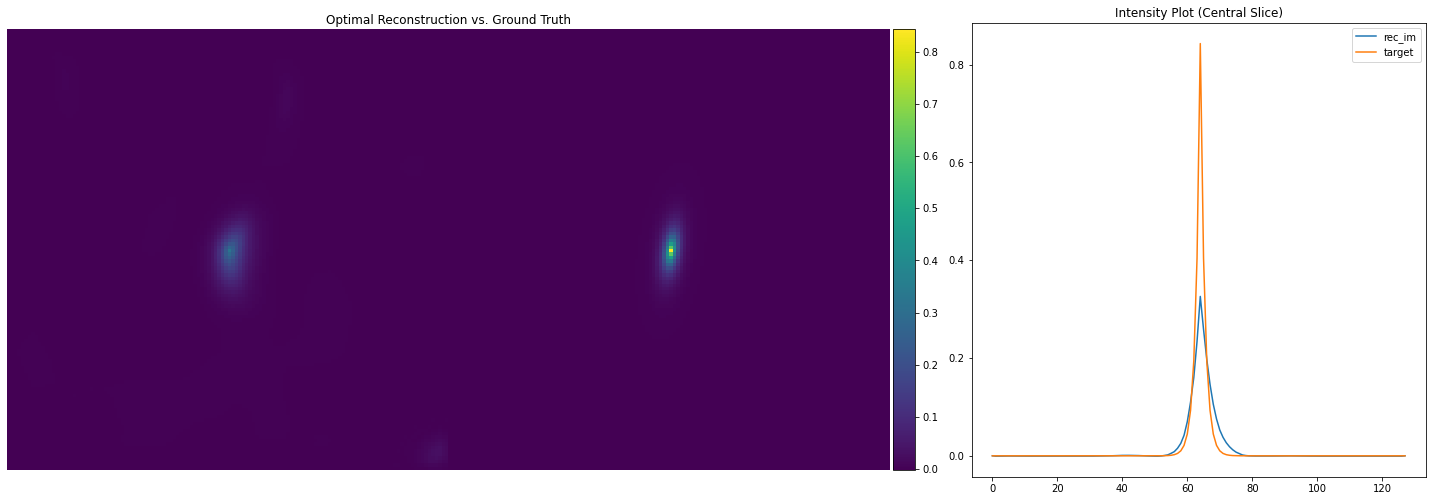

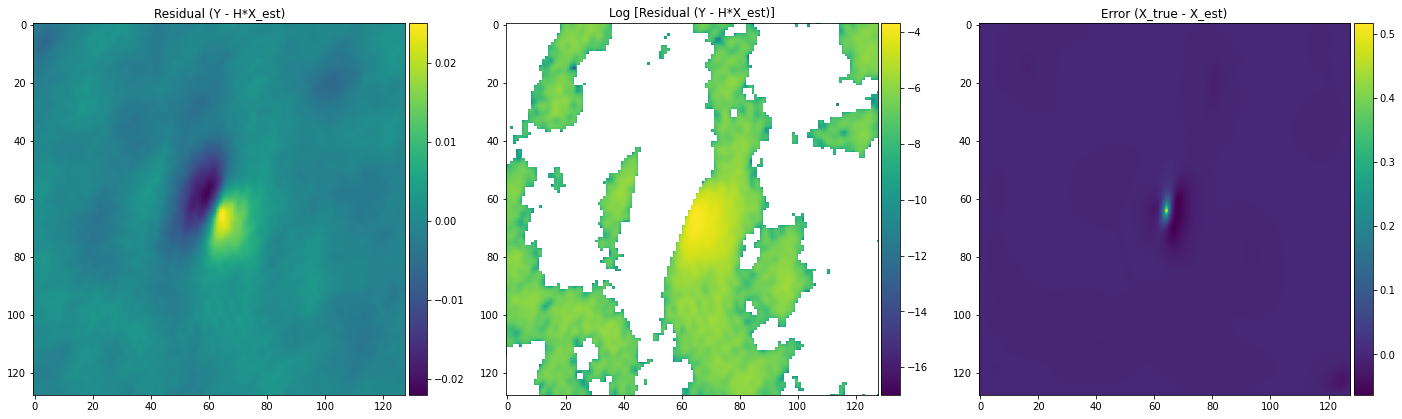

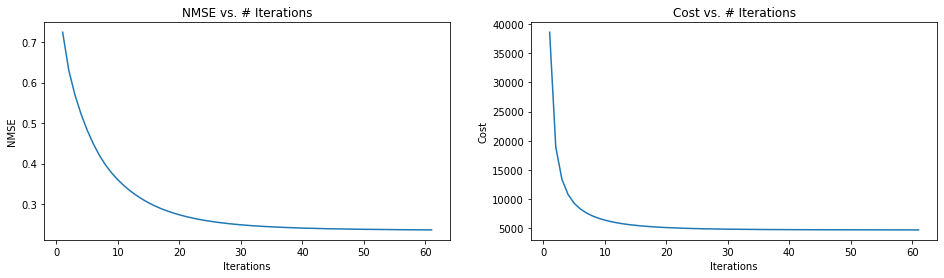


Minimum NMSE = 0.23618799448013306 (at [61] iterations)
Minimum Cost = 4711.98291015625 (at [61] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1490



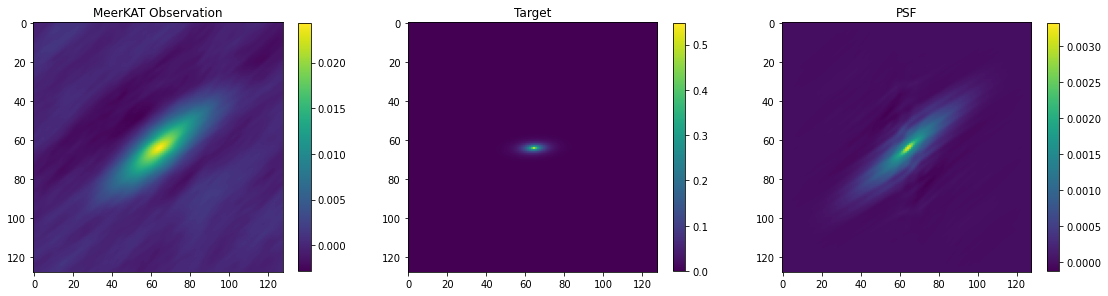

SNR (in Direct Space) = 27.20622716013849
Noise Std (in Direct Space) = 0.0008935028562555089
PSF Flux =  1.0000002



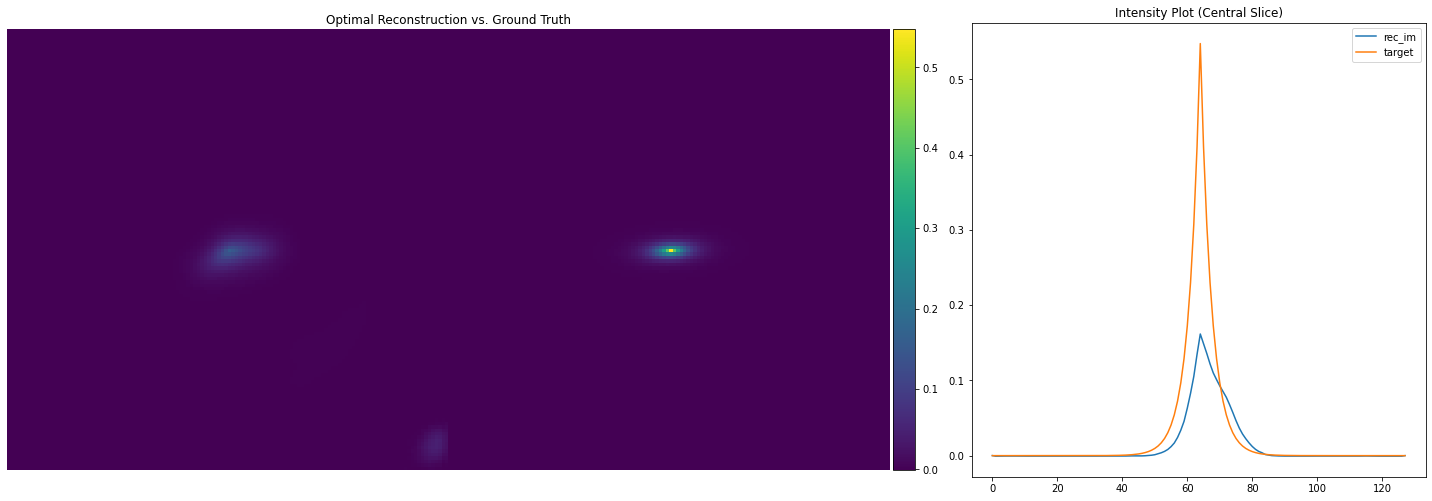

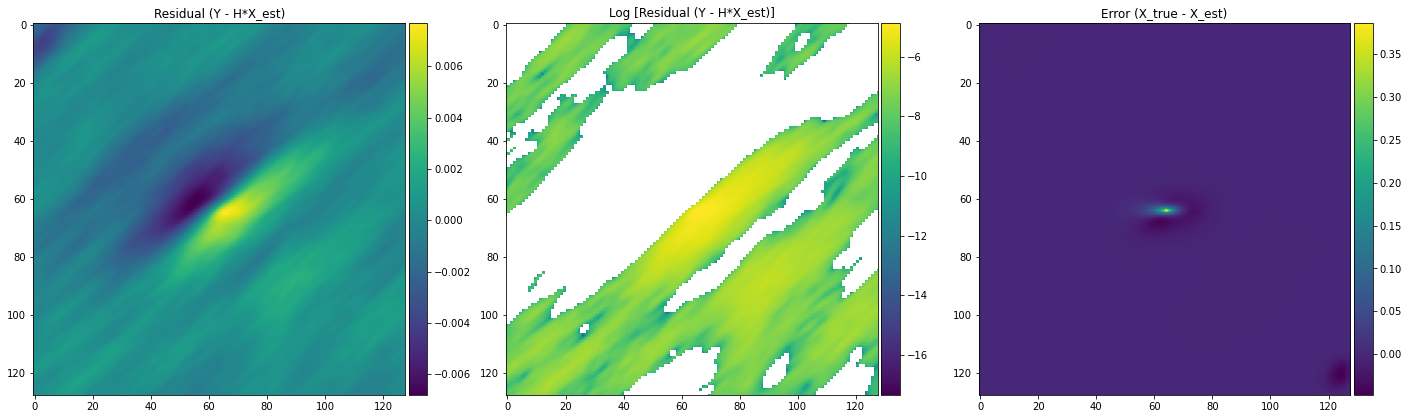

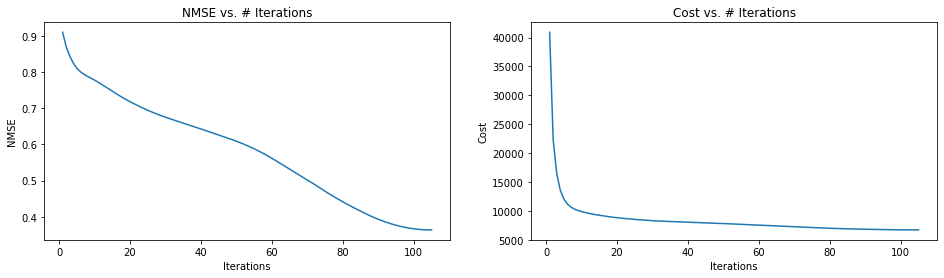


Minimum NMSE = 0.3634786903858185 (at [105] iterations)
Minimum Cost = 6701.8505859375 (at [105] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1480



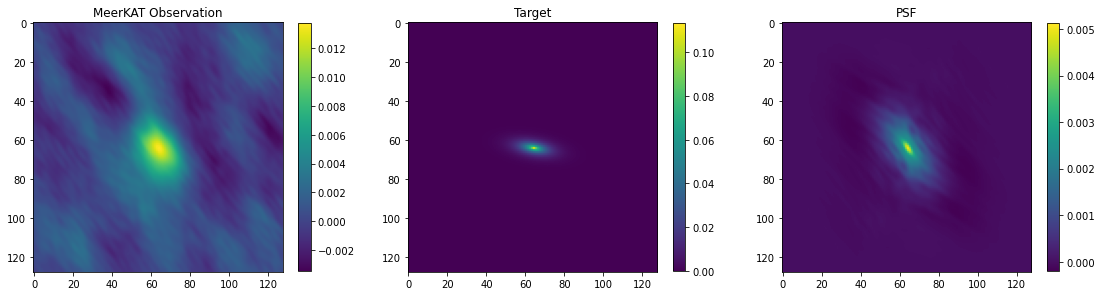

SNR (in Direct Space) = 9.155669446587432
Noise Std (in Direct Space) = 0.0014989124191459268
PSF Flux =  0.99999994



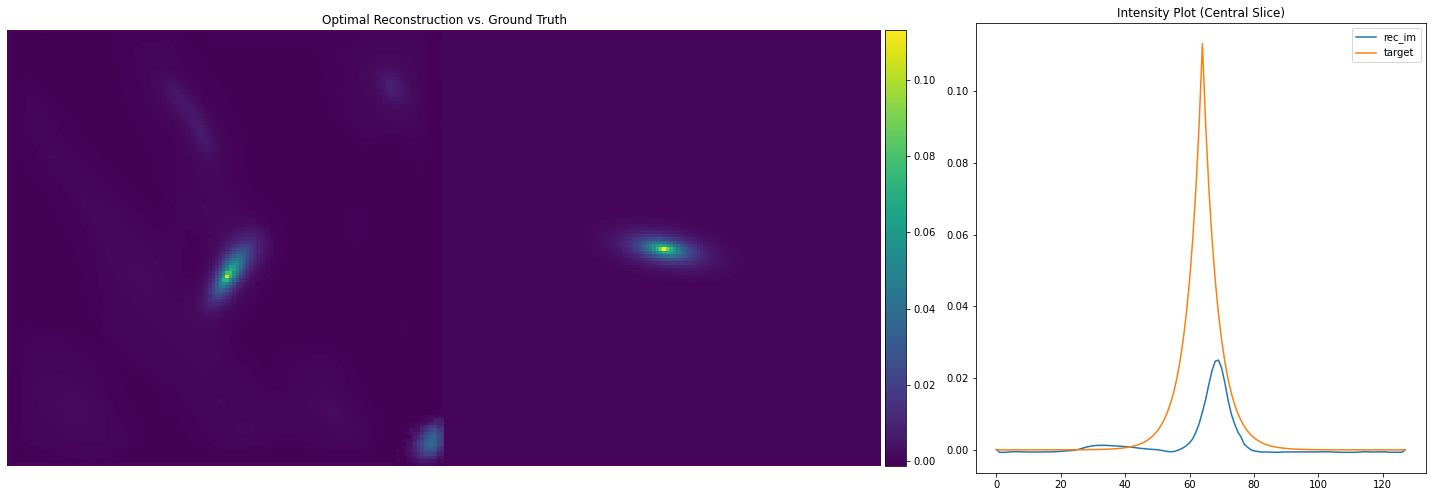

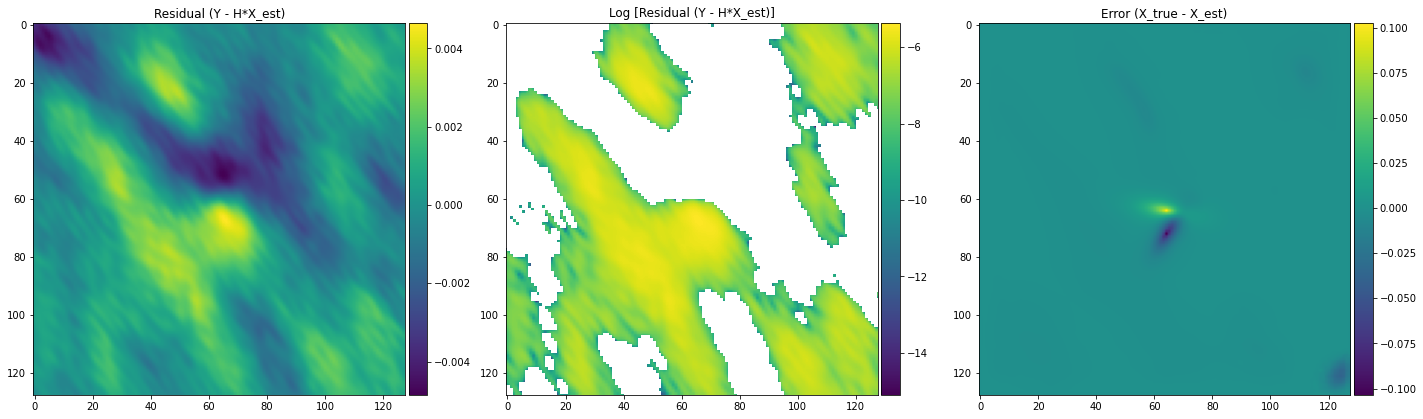

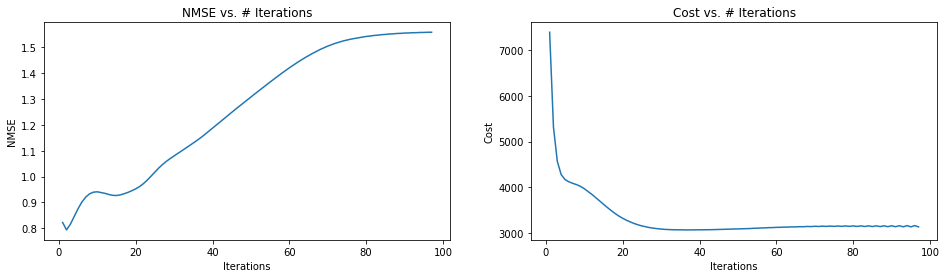


Minimum NMSE = 0.7940863370895386 (at [2] iterations)
Minimum Cost = 3065.227294921875 (at [37] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1470



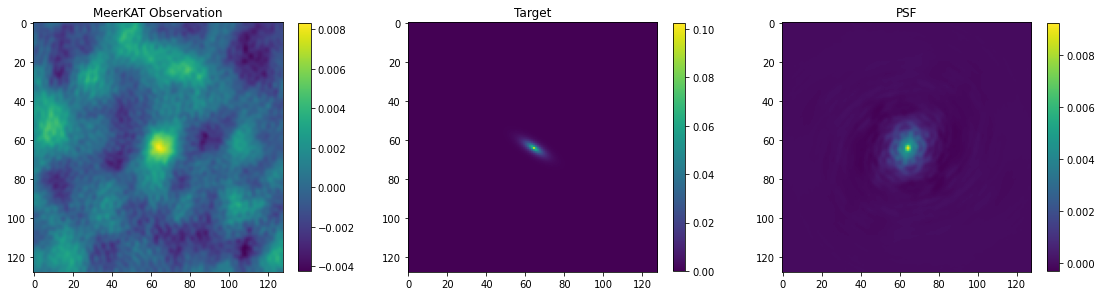

SNR (in Direct Space) = 5.51895787858728
Noise Std (in Direct Space) = 0.0015049764546565712
PSF Flux =  1.0000005



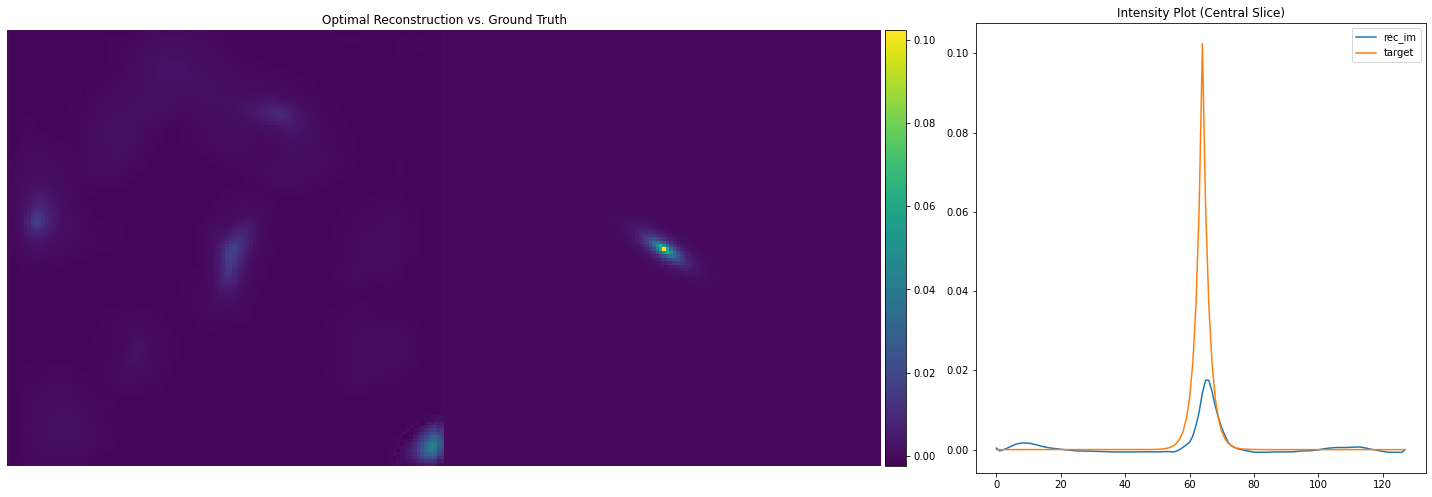

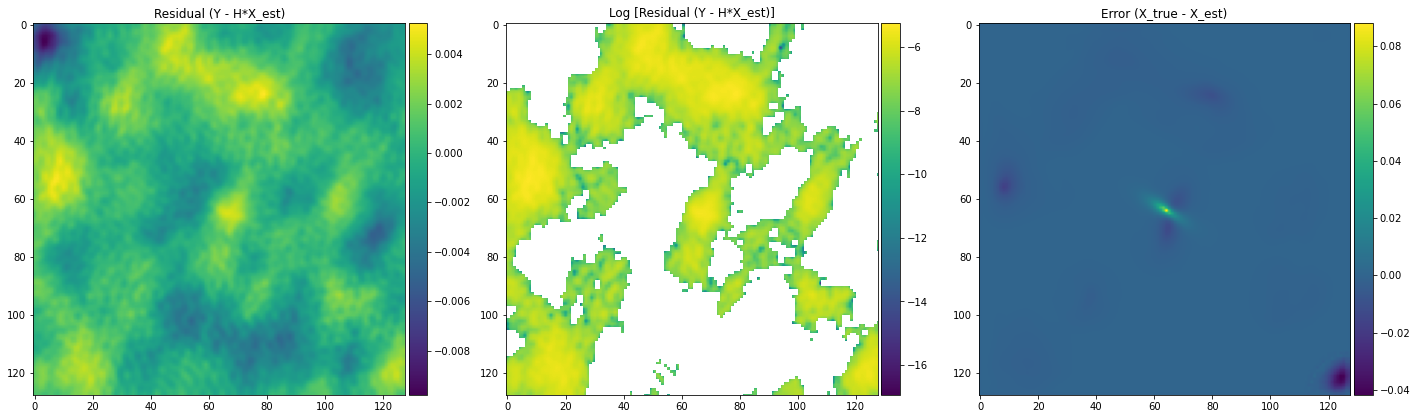

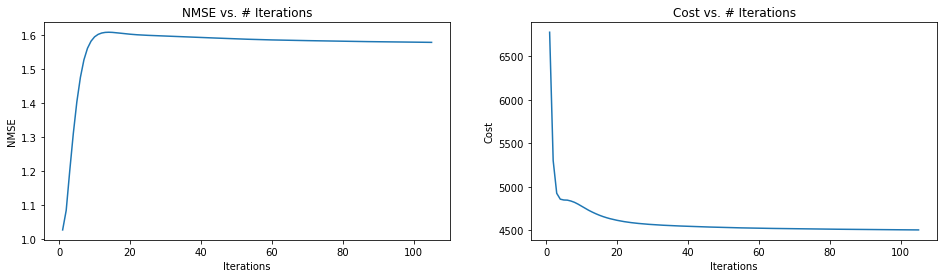


Minimum NMSE = 1.0275018215179443 (at [1] iterations)
Minimum Cost = 4505.2294921875 (at [105] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1460



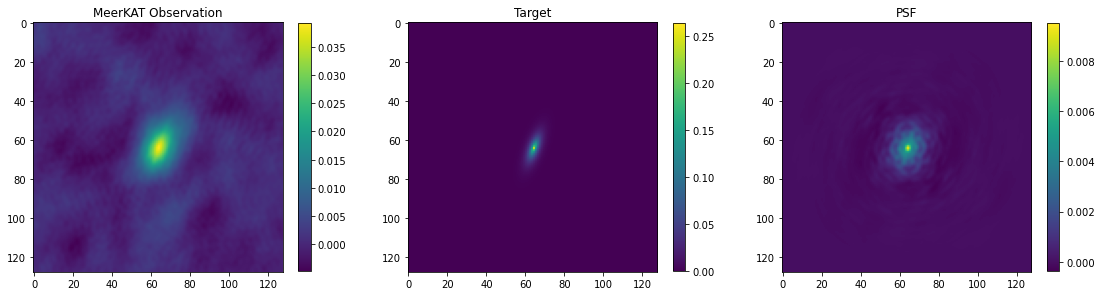

SNR (in Direct Space) = 22.18919261102072
Noise Std (in Direct Space) = 0.0017655325302388517
PSF Flux =  0.99999964



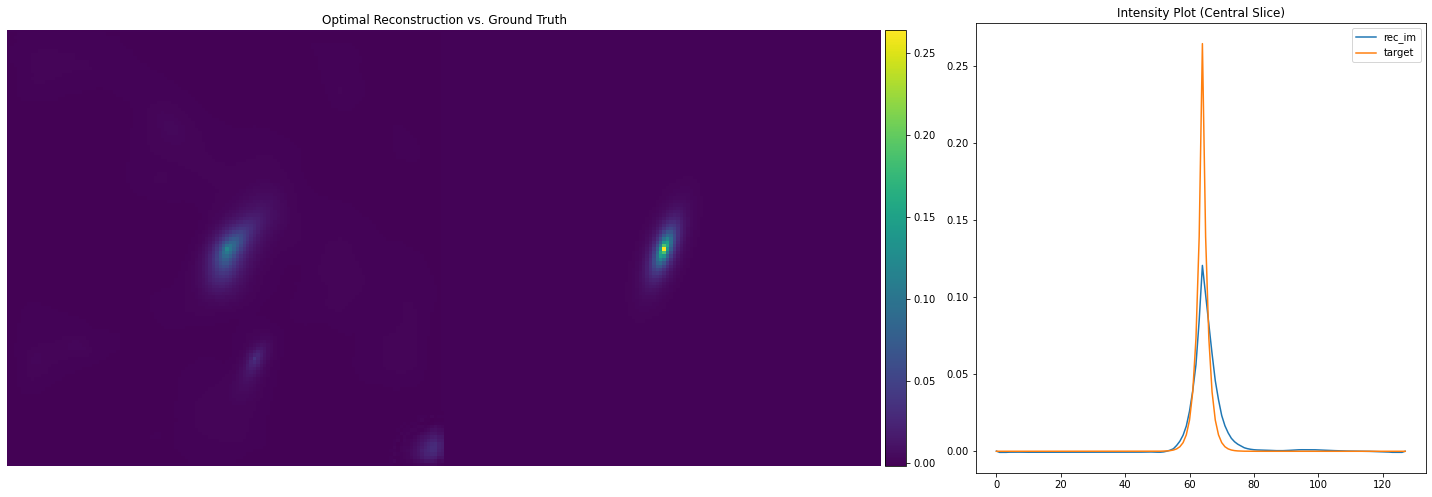

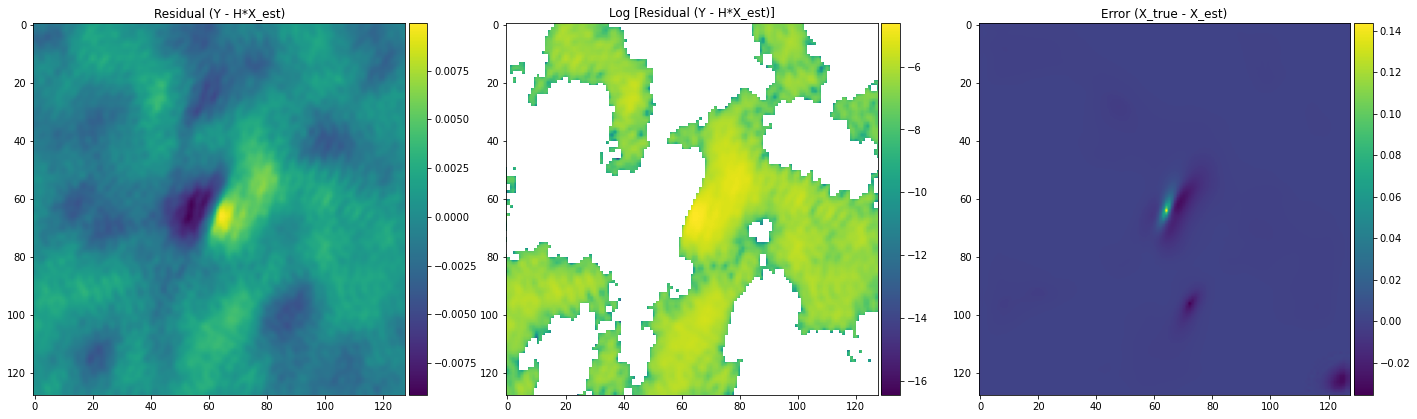

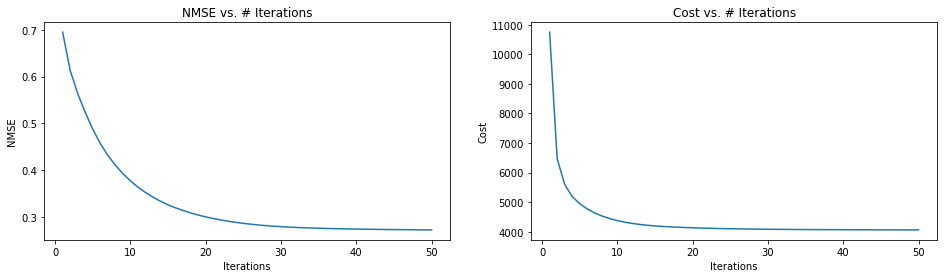


Minimum NMSE = 0.27251893281936646 (at [50] iterations)
Minimum Cost = 4060.815673828125 (at [50] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1450



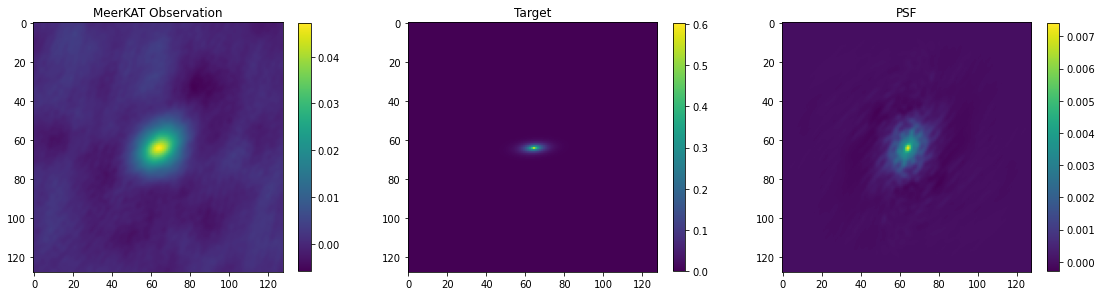

SNR (in Direct Space) = 26.991432429838127
Noise Std (in Direct Space) = 0.001747346809809096
PSF Flux =  1.0



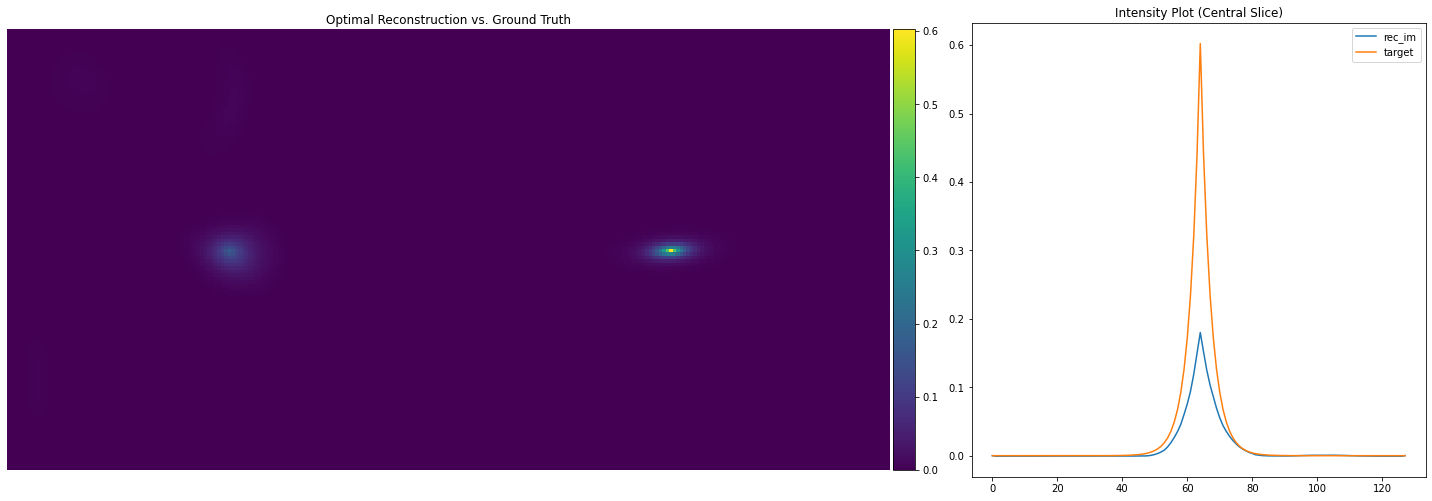

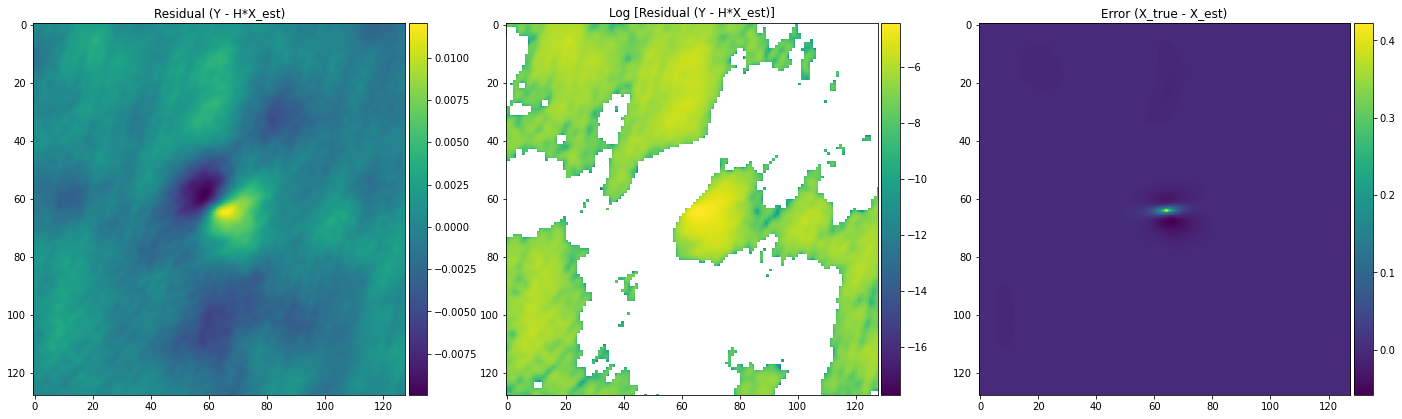

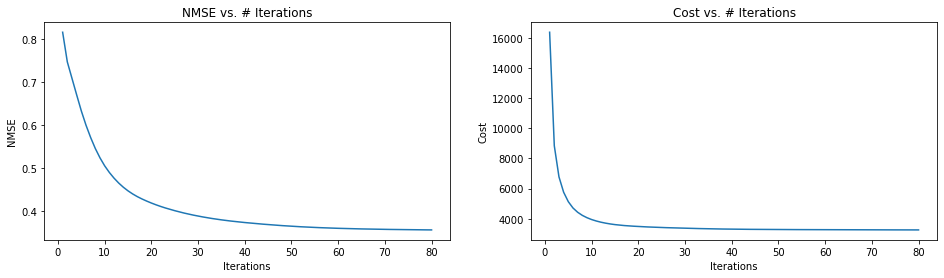


Minimum NMSE = 0.3563584089279175 (at [80] iterations)
Minimum Cost = 3254.416259765625 (at [80] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1440



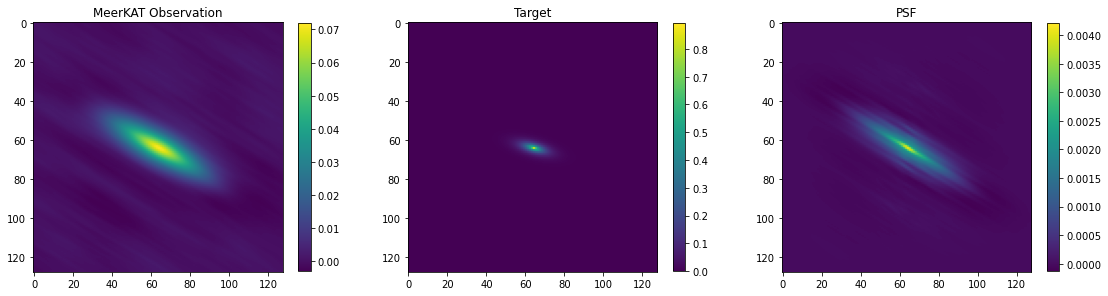

SNR (in Direct Space) = 66.1408892770529
Noise Std (in Direct Space) = 0.00108718246165663
PSF Flux =  0.99999964



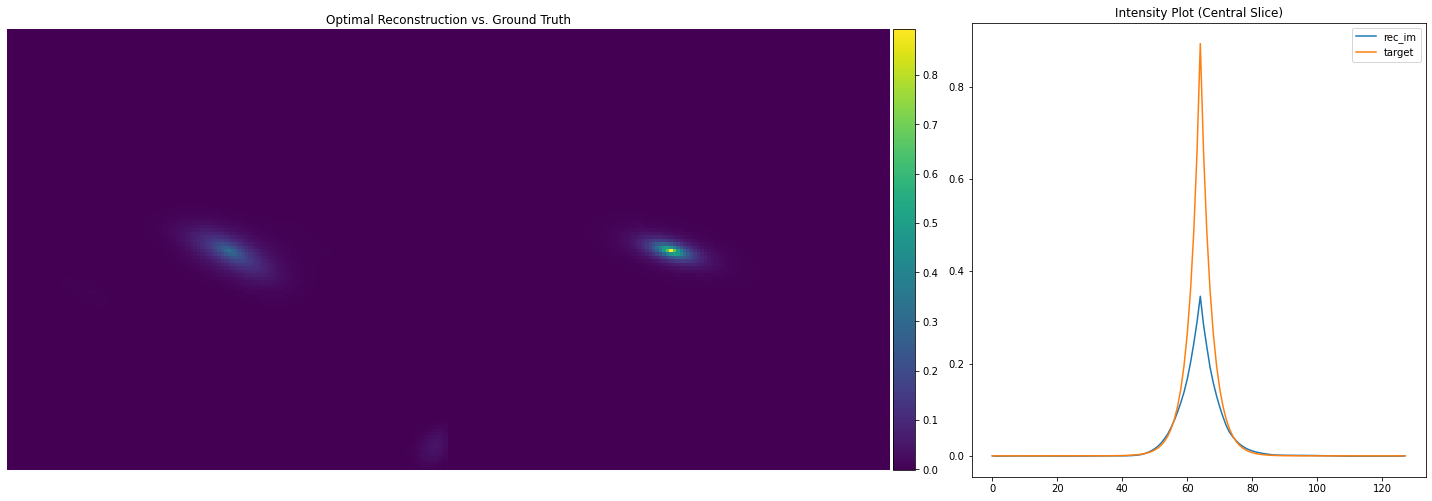

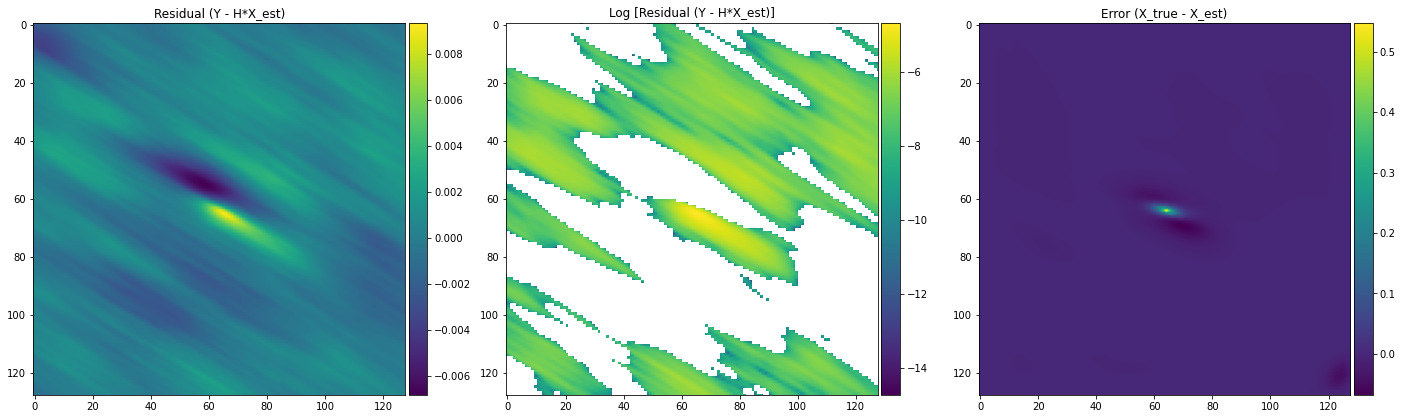

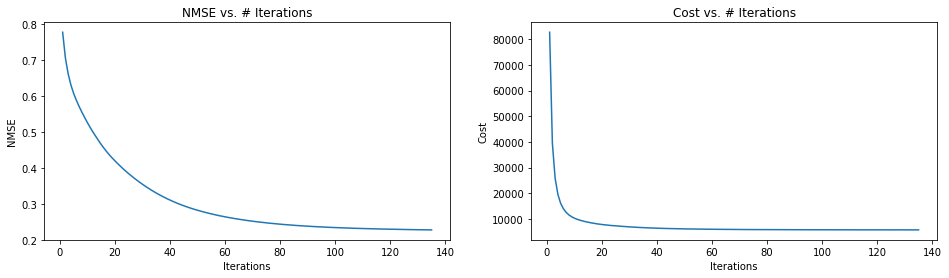


Minimum NMSE = 0.2271973192691803 (at [135] iterations)
Minimum Cost = 5701.1279296875 (at [135] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1430



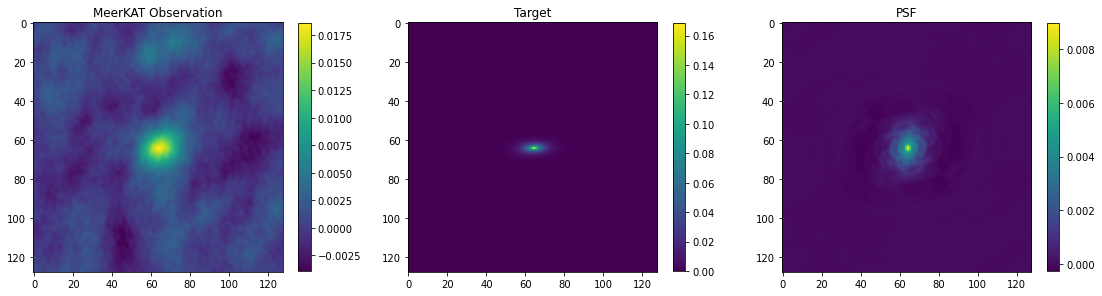

SNR (in Direct Space) = 12.90302512407445
Noise Std (in Direct Space) = 0.0014394049930851905
PSF Flux =  1.0000002



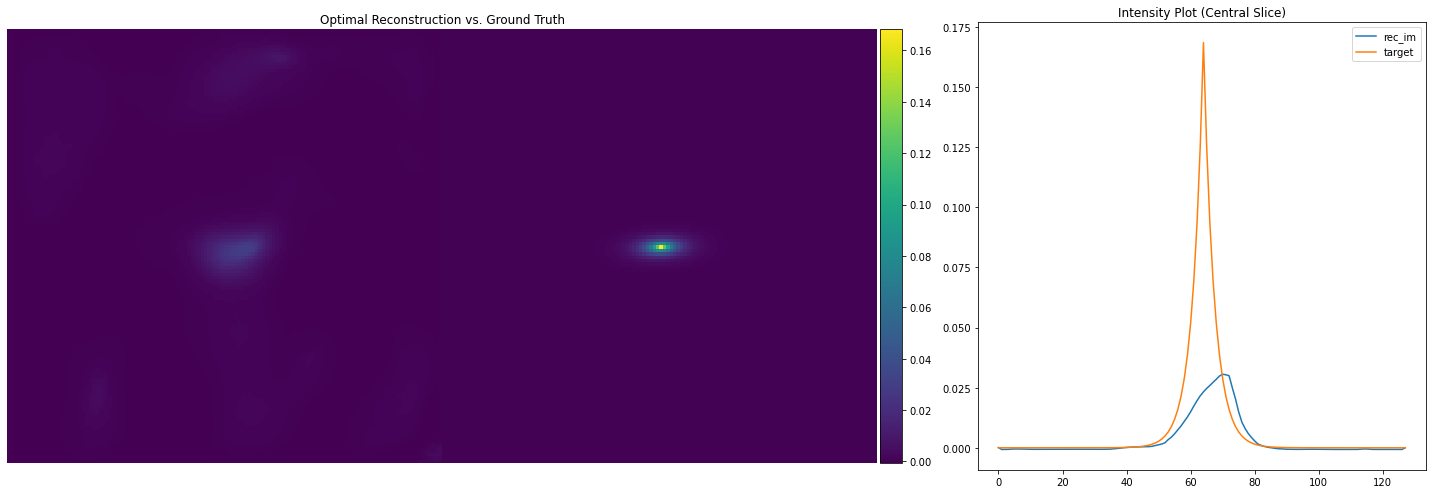

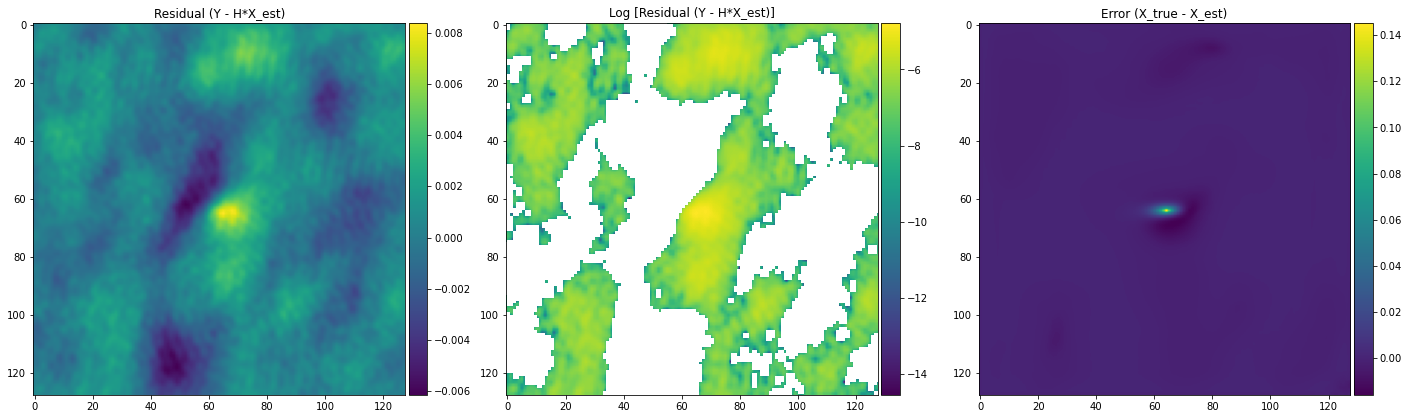

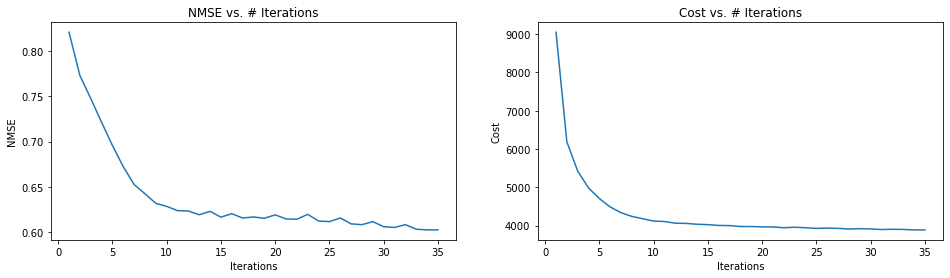


Minimum NMSE = 0.6024287939071655 (at [35] iterations)
Minimum Cost = 3887.55712890625 (at [34] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1420



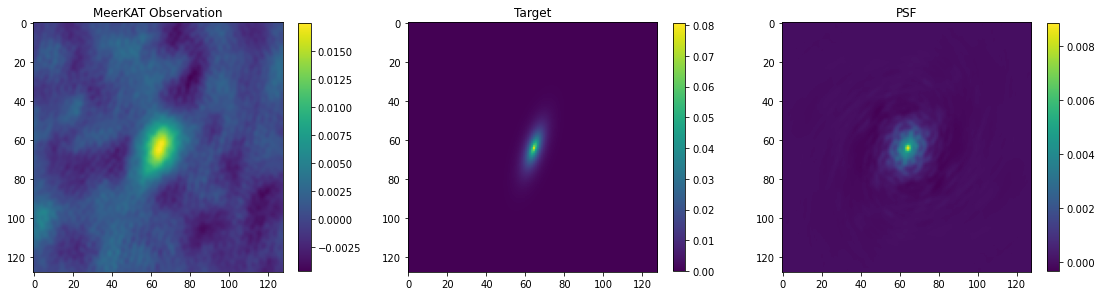

SNR (in Direct Space) = 10.606502560242326
Noise Std (in Direct Space) = 0.0016490400158800183
PSF Flux =  1.0000002



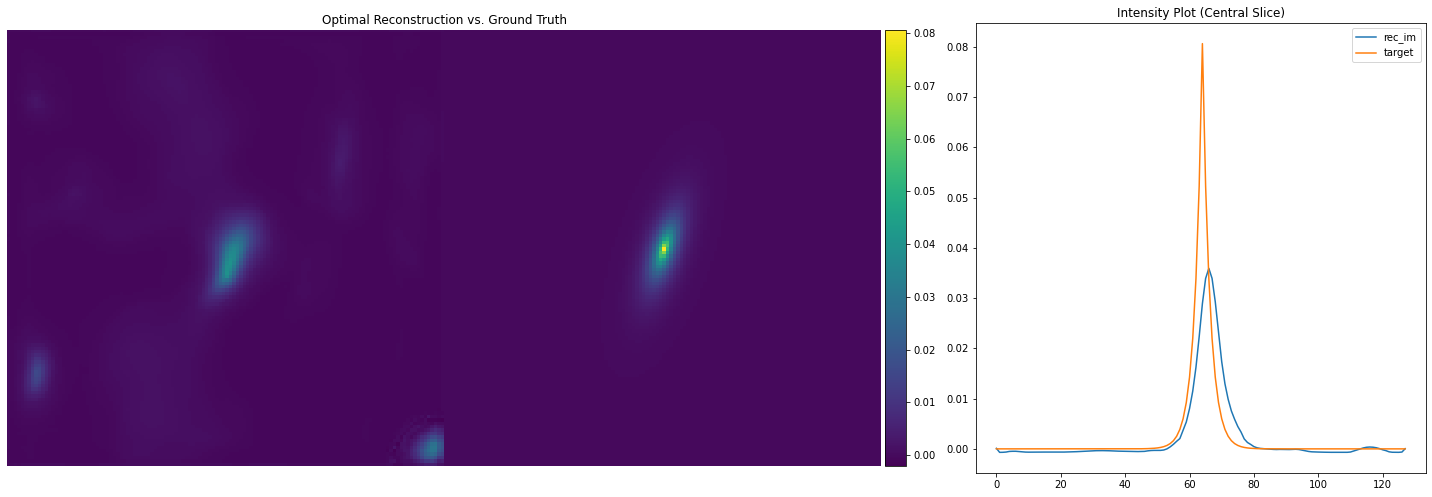

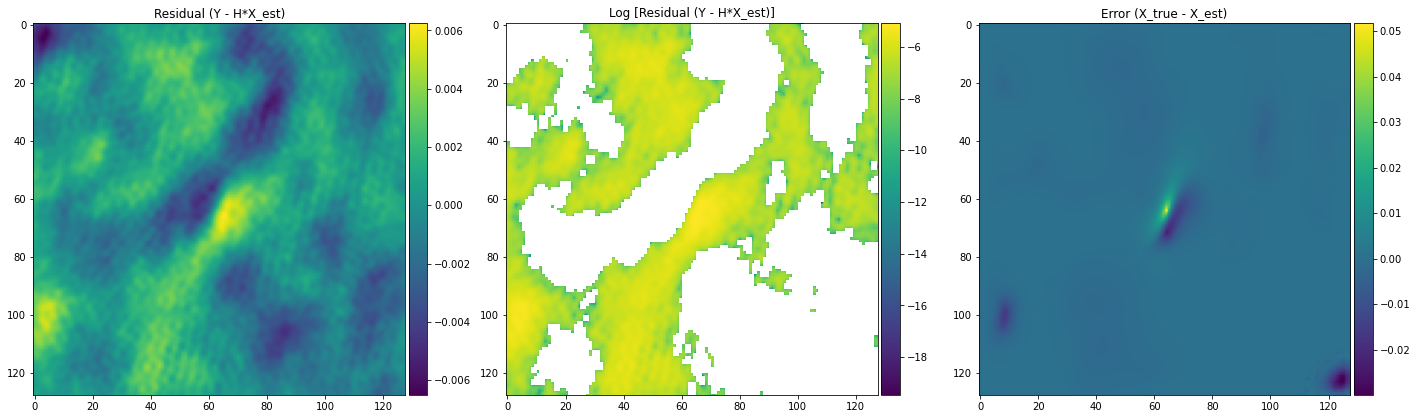

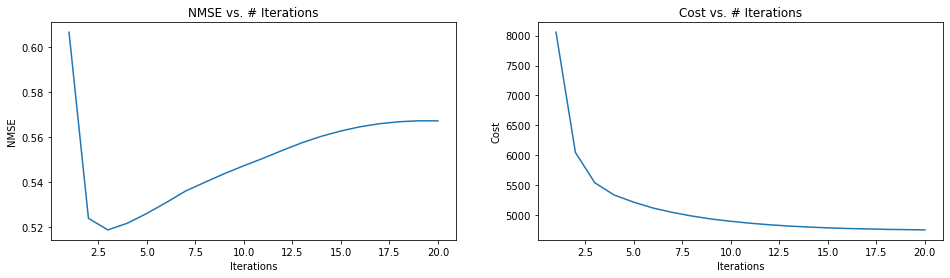


Minimum NMSE = 0.5188580751419067 (at [3] iterations)
Minimum Cost = 4746.39013671875 (at [20] iterations)

_______________________________________________________________________________________________________




 Galaxy Index = 1410



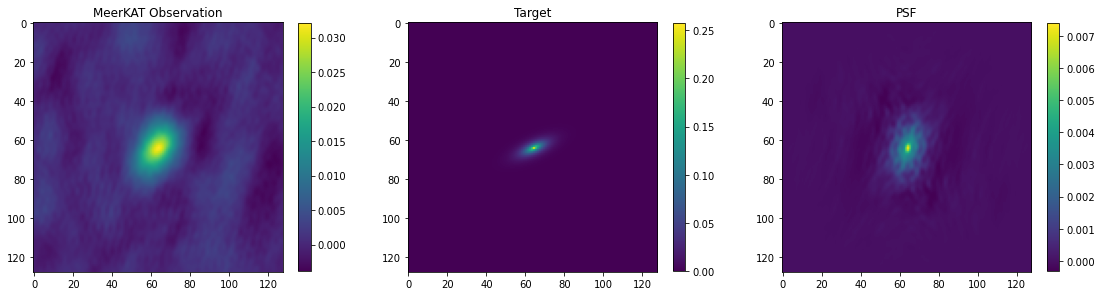

SNR (in Direct Space) = 22.111580906322608
Noise Std (in Direct Space) = 0.0014514667867217212
PSF Flux =  0.9999998



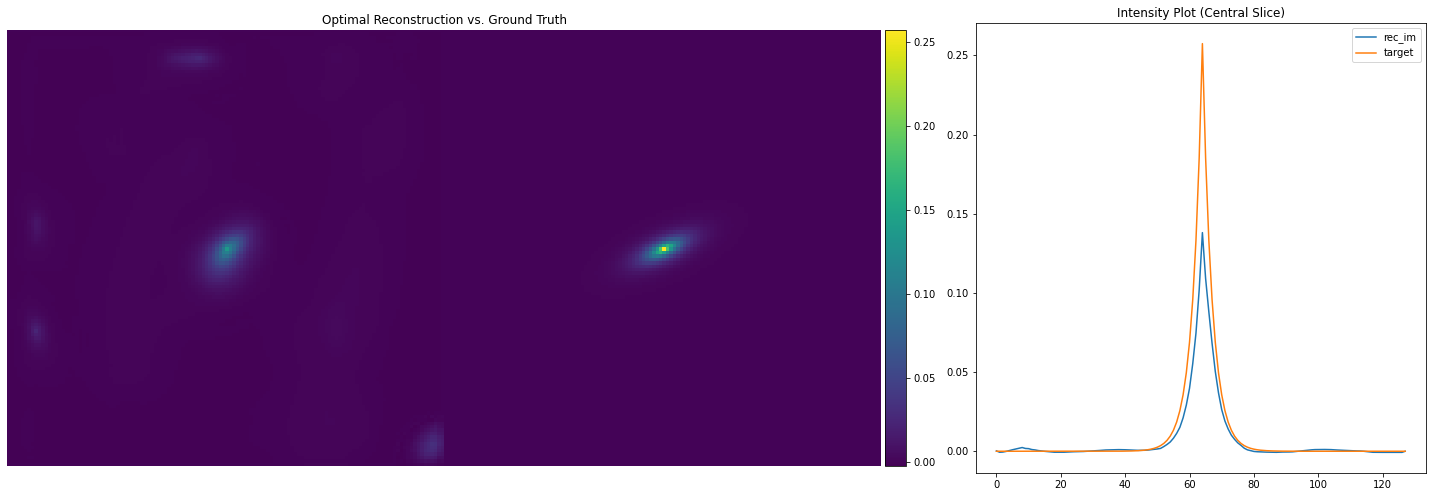

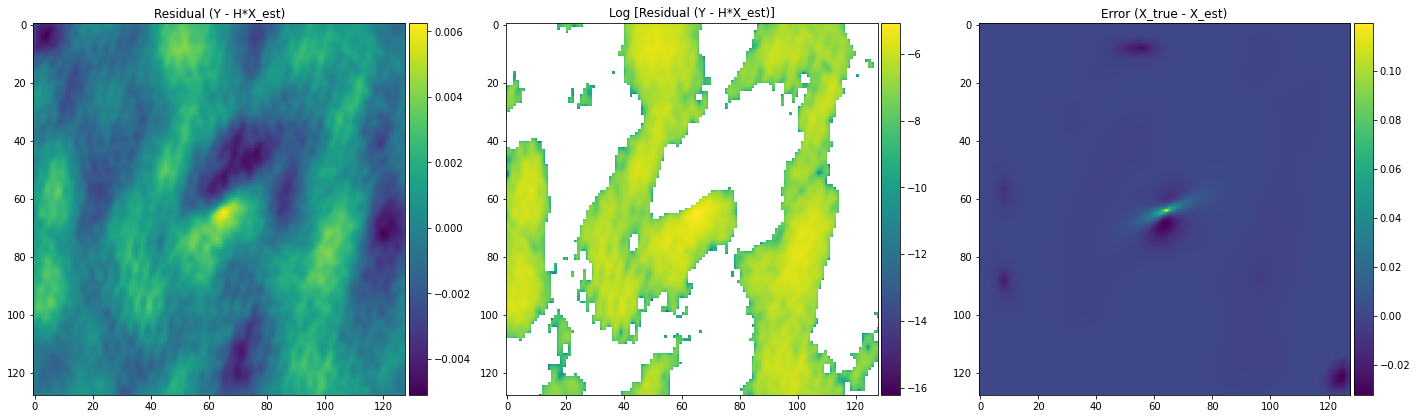

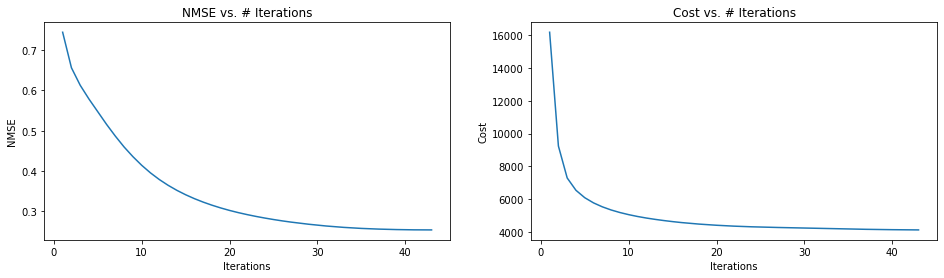


Minimum NMSE = 0.2543598711490631 (at [43] iterations)
Minimum Cost = 4120.33984375 (at [43] iterations)

_______________________________________________________________________________________________________




In [7]:
n_iter = 500

x_0 = np.zeros(batch['inputs'][0].shape)

x_opt = np.zeros((200, batch['inputs'].shape[1], batch['inputs'].shape[2]))                                 
nmse_arr = np.zeros((200, n_iter))          
cost = np.zeros((200, n_iter)) 


# Deconvolve given images
for gal_ind in range(1600, 1400, -1):            
    
    gal_input = tf.cast(np.squeeze(batch['inputs'][gal_ind]), tf.float32)
    gal_target = np.squeeze(batch['targets'][gal_ind])
    psf = tf.cast(np.squeeze(batch['psf'][gal_ind]) , tf.float32)       
    sigma_noise = sigma_mad(gal_input)    
    SNR_D = np.max(gal_input) / sigma_noise         # SNR in direct space
    
    if gal_ind%10 == 0:
        
        print('\n\n Galaxy Index = {}'.format(gal_ind))
        
        # Plot input, target & psf 
        plot_utils.plot_gal_psf_radio(gal_input, gal_target, psf, sigma_noise, SNR_D)

    # Deconvolve the image
    x_opt[1600-gal_ind], cost[1600-gal_ind], nmse_arr[1600-gal_ind] = runFISTA(gal_input, x_0, psf, grad, 
                                                                               sigma_noise, n_iter, model_1)
    if gal_ind%10 == 0:
        
        # Visual Comparison
        plot_utils.comparison(x_opt[1600-gal_ind], gal_target, gal_input, psf, fftconvolve)

        # Plot NMSE & Cost
        plot_utils.nmse_cost(nmse_arr[1600-gal_ind], cost[1600-gal_ind], n_iter)

### Save Output

In [8]:
FISTA_output_meerkat = {}
FISTA_output_meerkat['x_opt'] = x_opt
FISTA_output_meerkat['nmse'] = nmse_arr
FISTA_output_meerkat = dict(chain.from_iterable(d.items() for d in (FISTA_output_meerkat, batch)))

In [9]:
# Save FISTA Output
f = open(data_path + "FISTA_output_meerkat.pkl", "wb")
pickle.dump(FISTA_output_meerkat, f)
f.close()

### Check Saved Batch

In [10]:
# Load FISTA Output
f = open(data_path + "FISTA_output_meerkat.pkl", "rb")
dat = pickle.load(f)
f.close()

for key in dat:
    print(key, (dat[key] == FISTA_output_meerkat[key]).all())

x_opt True
nmse True
DEC True
HAstart True
e1 True
e2 True
flux True
index True
psf True
targets True
inputs True
